# ModerbBert Based Modeling for FOMC Prediction Project

In this notebook, we primarily focus on the ModernBert based modeling for our project. Specifically, we devide the notebook in different sections by processes:

1. Data handling, which includes Load Data & EDA, Make Dataset, and Text pre-processing
2. Modeling, which includes the modeling for both classfication task, and prediction task sperately. For prediction tasks we also have an extensive HPO section, the results of which are presented in the Appendix
3. Load model, which we also seperated by classification and regression task. This way we could more effectively preserve the checkpoints tried, and any specific model structure that we need to keep in order to load model properly for both tasks.
4. Check model results, which includes various post predicition analysis we did to check the sensibility of the predictions. It also calculates different metrics to measure the performance for different period/dataset. This also prepare for the data which can be used to conduct trading simuation / backtest in the later section. This section is also divided by classification and regression task, given the two tasks produce different types of output and need different metrics.
5. Backtest check, this is the section where we set up simple trading similation (backtest) to test the tradability of the signals from the predictions. Given the different nature of the predictions, we also divide this section by classification and prediction tasks.  

# Setting Environment

In [1]:
!pip install pdfplumber --quiet
!pip install optuna --quiet
import os
import re
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize
from datetime import datetime
from multiprocessing import Pool
# from tqdm import tqdm
import pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.8 MB/s eta 0:00:00


In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate
!pip install -q tokenizers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import json
import random
import logging
import optuna
import joblib
import gc
import pickle
from safetensors.torch import load_file

from datasets import load_dataset, Dataset as hf_Dataset
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, set_seed, EarlyStoppingCallback
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments, ModernBertForSequenceClassification, ModernBertModel, ModernBertForMaskedLM

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#IN - check directory list
%cd /content/drive/MyDrive/Datasci-266
%ls

Mounted at /content/drive
/content/drive/MyDrive/Datasci-266
Colab-notebooks-Datasci266/  DS266-final-project/  trainer_output/


In [ ]:
# Base directory for FOMC PDFs in Google Drive
# BASE_DIR = '/content/drive/My Drive/266_final/transcript_2020to2024'
BASE_DIR = '/content/drive/MyDrive/Datasci-266/DS266-final-project' # IN

# Data Handling

## Load data & EDA

In [ ]:
# if keeping original order of val and test:
train_years = [1980, 2012] # inclusive
val_years = [2013, 2018]
test_years = [2019, 2024]

# # if swapping val and test data:
# train_years = [1980, 2012] # inclusive
# test_years = [2013, 2018]
# val_years = [2019, 2024]

In [ ]:
# if keeping original order of val and test:
train_text = pd.read_csv(f'{BASE_DIR}/fomc_processed_data_train_mod_v2.csv')
val_text = pd.read_csv(f'{BASE_DIR}/fomc_processed_data_val_mod_v2.csv')
test_text = pd.read_csv(f'{BASE_DIR}/fomc_processed_data_test_mod_v2.csv')

train_mkt = pd.read_csv(f'{BASE_DIR}/mkt_daily_train_v4.csv')
val_mkt = pd.read_csv(f'{BASE_DIR}/mkt_daily_val_v4.csv')
test_mkt = pd.read_csv(f'{BASE_DIR}/mkt_daily_test_v4.csv')


# # if swapping val and test data:
# train_text = pd.read_csv(f'{BASE_DIR}/fomc_processed_data_train_mod_v2.csv')
# test_text = pd.read_csv(f'{BASE_DIR}/fomc_processed_data_val_mod_v2.csv')
# val_text = pd.read_csv(f'{BASE_DIR}/fomc_processed_data_test_mod_v2.csv')

# train_mkt = pd.read_csv(f'{BASE_DIR}/mkt_daily_train_v4.csv')
# test_mkt = pd.read_csv(f'{BASE_DIR}/mkt_daily_val_v4.csv')
# val_mkt = pd.read_csv(f'{BASE_DIR}/mkt_daily_test_v4.csv')

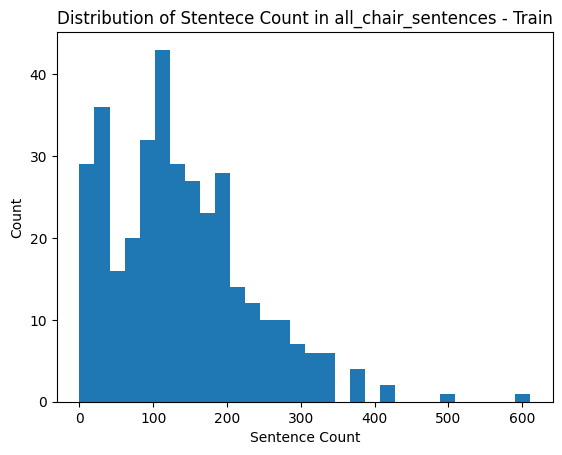

count    356.000000
mean     138.044944
std       94.292402
min        0.000000
25%       68.000000
50%      124.500000
75%      192.000000
max      611.000000
Name: all_chair_sentences, dtype: float64

In [ ]:
# for train - sentences
train_text['all_chair_sentences'].apply(lambda x: len(ast.literal_eval(x))).plot.hist(bins=30)
plt.title('Distribution of Stentece Count in all_chair_sentences - Train')
plt.xlabel('Sentence Count')
plt.ylabel('Count')
plt.show()

train_text['all_chair_sentences'].apply(lambda x: len(ast.literal_eval(x))).describe()

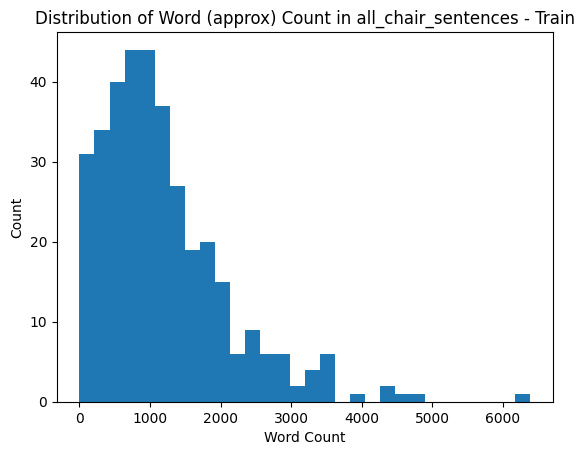

count     356.000000
mean     1197.730337
std       917.775731
min         1.000000
25%       565.000000
50%       998.500000
75%      1562.500000
max      6387.000000
Name: all_chair_words, dtype: float64

In [ ]:
# for train - words
train_text['all_chair_sentences'].apply(lambda x: len(x.split())).plot.hist(bins=30)
plt.title('Distribution of Word (approx) Count in all_chair_sentences - Train')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()

train_text['all_chair_sentences'].apply(lambda x: len(x.split())).rename('all_chair_words').describe()

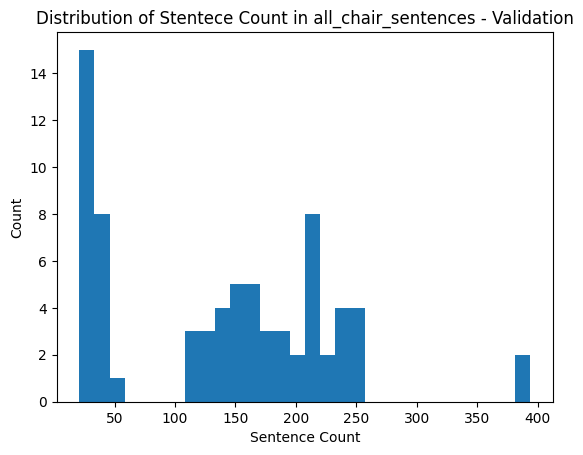

count     72.000000
mean     139.208333
std       90.618211
min       21.000000
25%       36.500000
50%      148.500000
75%      209.000000
max      394.000000
Name: all_chair_sentences, dtype: float64

In [ ]:
## For val_text - sentences
val_text['all_chair_sentences'].apply(lambda x: len(ast.literal_eval(x))).plot.hist(bins=30)
plt.title('Distribution of Stentece Count in all_chair_sentences - Validation')
plt.xlabel('Sentence Count')
plt.ylabel('Count')
plt.show()

val_text['all_chair_sentences'].apply(lambda x: len(ast.literal_eval(x))).describe()

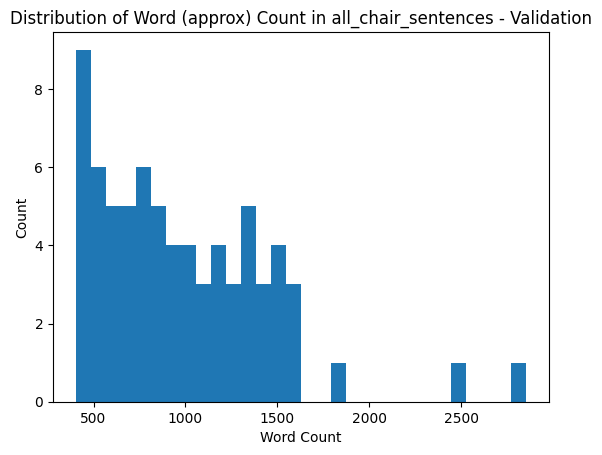

count      72.000000
mean      983.694444
std       473.726094
min       402.000000
25%       615.750000
50%       892.000000
75%      1277.250000
max      2855.000000
Name: all_chair_words, dtype: float64

In [ ]:
## For val_text - words
val_text['all_chair_sentences'].apply(lambda x: len(x.split())).plot.hist(bins=30)
plt.title('Distribution of Word (approx) Count in all_chair_sentences - Validation')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()

val_text['all_chair_sentences'].apply(lambda x: len(x.split())).rename('all_chair_words').describe()

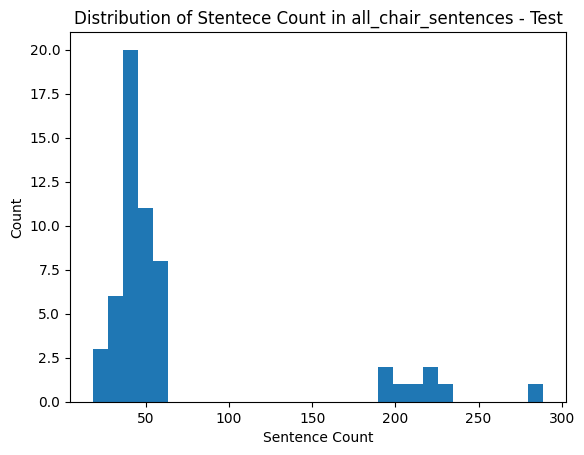

count     56.000000
mean      69.428571
std       63.821871
min       18.000000
25%       39.750000
50%       45.000000
75%       55.250000
max      289.000000
Name: all_chair_sentences, dtype: float64

In [ ]:
## For test_text - sentences
test_text['all_chair_sentences'].apply(lambda x: len(ast.literal_eval(x))).plot.hist(bins=30)
plt.title('Distribution of Stentece Count in all_chair_sentences - Test')
plt.xlabel('Sentence Count')
plt.ylabel('Count')
plt.show()

test_text['all_chair_sentences'].apply(lambda x: len(ast.literal_eval(x))).describe()

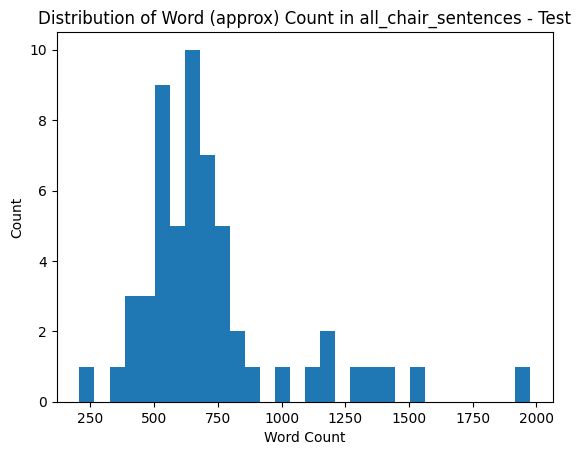

count      56.000000
mean      726.946429
std       317.395733
min       207.000000
25%       546.000000
50%       666.000000
75%       759.750000
max      1976.000000
Name: all_chair_words, dtype: float64

In [ ]:
## For test_text - words
test_text['all_chair_sentences'].apply(lambda x: len(x.split())).plot.hist(bins=30)
plt.title('Distribution of Word (approx) Count in all_chair_sentences - Test')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()

test_text['all_chair_sentences'].apply(lambda x: len(x.split())).rename('all_chair_words').describe()

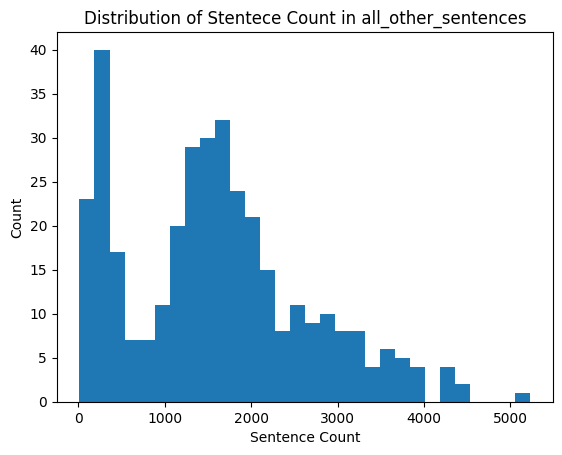

In [ ]:
train_text['all_other_sentences'].apply(lambda x: len(ast.literal_eval(x))).plot.hist(bins=30)
plt.title('Distribution of Stentece Count in all_other_sentences')
plt.xlabel('Sentence Count')
plt.ylabel('Count')
plt.show()

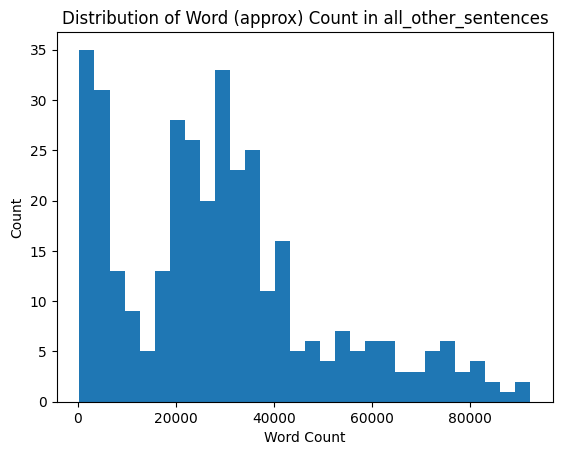

In [ ]:
train_text['all_other_sentences'].apply(lambda x: len(x.split())).plot.hist(bins=30)
plt.title('Distribution of Word (approx) Count in all_other_sentences')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()

IN: brief conclusion: even though if we want to process the entire document each time at once could exceed modernBERT's limit, processing all chairman's words at words are more than enough.

In [ ]:
train_text[['date','all_chair_sentences']].head()

date                                all_chair_sentences
0  1980-01-09  ['CHAIRMAN VOLCKER: [That was the change in Sy...
1  1980-02-05  ['CHAIRMAN VOLCKER: I will call the non-meetin...
2  1980-03-07  ['CHAIRMAN VOLCKER: I doubt that we have to be...
3  1980-03-18  ['CHAIRMAN VOLCKER: The meeting can come to or...
4  1980-04-22  ['CHAIRMAN VOLCKER: Can we come to order, ladi...

In [ ]:
train_text[['date','all_chair_sentences']].tail()

date                                all_chair_sentences
351  2012-09-13  ['CHAIRMAN BERNANKE: Good morning, everybody.'...
352  2012-09-13  ['CHAIRMAN BERNANKE: Good afternoon.', 'CHAIRM...
353  2012-10-24  ['CHAIRMAN BERNANKE: Good afternoon, everybody...
354  2012-12-12  ['CHAIRMAN BERNANKE: Good morning, everyone.',...
355  2012-12-12  ['CHAIRMAN BERNANKE: Good afternoon.', 'CHAIRM...

## Make dataset

In [ ]:
def prep_data(df, mkt_df, input_col, tgt_cols):
  mkt_df['Date'] = pd.to_datetime(mkt_df['Date'])
  # mkt_df['vix_pct_diff'] = mkt_df['vix'].pct_change() # IN: remove vix for now given not long enough data series
  mkt_df['tsy10yr_diff'] = mkt_df['tsy10yr'].diff()
  mkt_df['tsy5yr_diff'] = mkt_df['tsy5yr'].diff()
  # mkt_df['infl_exp_mnth_diff'] = mkt_df[['Date','infl_exp_mnth']].set_index('Date')\
  #                             .asfreq('MS').loc['1982-01':,:].diff().shift(-1).asfreq('D').ffill()\
  #                             .reindex(mkt_df['Date']).fillna(0).reset_index()['infl_exp_mnth']/2*10
  mkt_df['infl_exp_diff_nxtm'] = mkt_df['infl_exp_diff_nxtm'].fillna(0)/2

                              #IN: try to calculate next month's monthly infl exp change, \
                              #after ffill, fill leading na with zero so we dont lose all initial records.
                              #devide amount by 2, so later 2-day sum is the actual monthly chg
                              #multiply by 10 to make it align with other targets' scale (optional)
  mkt_df_used = mkt_df.set_index('Date')[['_'.join(x.split('_')[1:]) for x in tgt_cols]]\
                .apply(lambda x: x.rolling(2).sum().shift(-2), axis=0).dropna()
  mkt_df_used.columns = tgt_cols
  mkt_df_used.reset_index(inplace=True)
  display(mkt_df_used.head())

  df_used = df[['date', input_col]].copy()
  df_used = df.drop_duplicates(subset=['date'], keep='first')
  # knowing there would be duplicates by date, keep the first
  df_used['input_text'] = df_used[input_col].apply(lambda x: ast.literal_eval(x))
  df_used['date'] = pd.to_datetime(df_used['date'])

  df_used.drop(columns=[input_col], inplace=True)
  df_used = pd.merge(df_used, mkt_df_used[['Date']+tgt_cols], left_on='date', right_on='Date', how='left').drop(columns=['Date'])
  df_used.sort_values('date', inplace=True)
  df_used.reset_index(drop=True, inplace=True)
  return df_used

input_col = 'all_chair_sentences'
# tgt_cols = ['next2d_sp_return', 'next2d_vix_pct_diff', 'next2d_tsy10yr_diff', 'next2d_tsy5yr_diff']
tgt_cols = ['next2d_sp_return', 'next2d_tsy10yr_diff', 'next2d_tsy5yr_diff']
# tgt_cols = ['next2d_sp_return']
train_used = prep_data(train_text, train_mkt, input_col, tgt_cols)
val_used = prep_data(val_text, val_mkt, input_col, tgt_cols)
test_used = prep_data(test_text, test_mkt, input_col, tgt_cols)


Date  next2d_sp_return  next2d_tsy10yr_diff  next2d_tsy5yr_diff
0 1980-01-02          0.007249               0.0016              0.0010
1 1980-01-03          0.015078               0.0003              0.0002
2 1980-01-04          0.022758              -0.0009             -0.0010
3 1980-01-07          0.020953              -0.0005             -0.0003
4 1980-01-08          0.008621              -0.0006             -0.0005

Date  next2d_sp_return  next2d_tsy10yr_diff  next2d_tsy5yr_diff
0 2013-01-02          0.002779              0.00076             0.00056
1 2013-01-03          0.001742              0.00004             0.00005
2 2013-01-04         -0.006365             -0.00044            -0.00034
3 2013-01-07         -0.000587             -0.00051            -0.00052
4 2013-01-08          0.010253              0.00023             0.00008

Date  next2d_sp_return  next2d_tsy10yr_diff  next2d_tsy5yr_diff
0 2019-01-02          0.009579             -0.00002            -0.00021
1 2019-01-03          0.041346              0.00128             0.00151
2 2019-01-04          0.016706              0.00057             0.00089
3 2019-01-07          0.013793              0.00046             0.00040
4 2019-01-08          0.008616              0.00015            -0.00012

In [ ]:
train_used.head()

date                            interest_rate_sentences  \
0 1980-01-09  ['CHAIRMAN VOLCKER: What plausible reason do y...   
1 1980-02-05  ['CHAIRMAN VOLCKER: If interest rates decline,...   
2 1980-03-07  ["CHAIRMAN VOLCKER: END OF MEETING 1/S ecretar...   
3 1980-03-18  ["CHAIRMAN VOLCKER: I think we'd have to say t...   
4 1980-04-22  ['CHAIRMAN VOLCKER: What are German interest r...   

  asset_purchasing_sentences gdp_sentences  \
0                         []            []   
1                         []            []   
2                         []            []   
3                         []            []   
4                         []            []   

                                 inflation_sentences  \
0  ["CHAIRMAN VOLCKER: Did I understand you corre...   
1  ['CHAIRMAN VOLCKER: This shows a rising rate o...   
2                                                 []   
3  ['CHAIRMAN VOLCKER: There is a great concern i...   
4  ["CHAIRMAN VOLCKER: The consumer price index i...   

                                employment_sentences  \
0                                                 []   
1  ['CHAIRMAN VOLCKER: Did you have an unemployme...   
2                                                 []   
3                                                 []   
4                                                 []   

                                 all_other_sentences  \
0  ['in Washington, D: C., starting on Tuesday, J...   
1  ['in Washington, D: C., starting on Monday, Fe...   
2  ['held on Friday, March 7, 1980: This was a te...   
3  ['Reserve System in Washington, D: C., on Tues...   
4  ['Washington, D: C., on Tuesday, April 22, 198...   

                                          input_text  next2d_sp_return  \
0  [CHAIRMAN VOLCKER: [That was the change in Sys...          0.007976   
1  [CHAIRMAN VOLCKER: I will call the non-meeting...          0.014084   
2  [CHAIRMAN VOLCKER: I doubt that we have to be ...          0.008275   
3  [CHAIRMAN VOLCKER: The meeting can come to ord...         -0.009391   
4  [CHAIRMAN VOLCKER: Can we come to order, ladie...          0.009360   

   next2d_tsy10yr_diff  next2d_tsy5yr_diff  
0               0.0010              0.0008  
1              -0.0002             -0.0019  
2              -0.0045             -0.0061  
3               0.0022              0.0031  
4               0.0014              0.0018

In [ ]:
train_used.tail()

date                            interest_rate_sentences  \
343 2012-06-20  ['CHAIRMAN BERNANKE: And even though term prem...   
344 2012-08-01  ['CHAIRMAN BERNANKE: Those projections are hig...   
345 2012-09-13             ['CHAIRMAN BERNANKE: Releasing what?']   
346 2012-10-24  ['CHAIRMAN BERNANKE: The way I interpret what ...   
347 2012-12-12  ['CHAIRMAN BERNANKE: Assuming what interest ra...   

                            asset_purchasing_sentences gdp_sentences  \
343                                                 []            []   
344                                                 []            []   
345                                                 []            []   
346                                                 []            []   
347  ['CHAIRMAN BERNANKE: This vote is on open mark...            []   

                                   inflation_sentences  \
343  ['CHAIRMAN BERNANKE: And even though term prem...   
344  ['CHAIRMAN BERNANKE: Of course, there are hous...   
345                                                 []   
346  ['CHAIRMAN BERNANKE: President Fisher, I’d jus...   
347                                                 []   

                                  employment_sentences  \
343  ['CHAIRMAN BERNANKE: President Fisher, I think...   
344  ['Chairman can explain at the press conference...   
345  ['CHAIRMAN BERNANKE: “Federal Reserve Will Pro...   
346                                                 []   
347  ['CHAIRMAN BERNANKE: Do you recall what their ...   

                                   all_other_sentences  \
343  ['Governors of the Federal Reserve System in W...   
344  ['Governors of the Federal Reserve System in W...   
345  ['Governors of the Federal Reserve System in W...   
346  ['Governors of the Federal Reserve System in W...   
347  ['Governors of the Federal Reserve System in W...   

                                            input_text  next2d_sp_return  \
343  [CHAIRMAN BERNANKE: Good morning., CHAIRMAN BE...         -0.015087   
344  [CHAIRMAN BERNANKE: Good afternoon, everybody....          0.011537   
345  [CHAIRMAN BERNANKE: Good morning, everybody., ...          0.000834   
346  [CHAIRMAN BERNANKE: Good afternoon, everybody....          0.002267   
347  [CHAIRMAN BERNANKE: Good morning, everyone., C...         -0.010457   

     next2d_tsy10yr_diff  next2d_tsy5yr_diff  
343              0.00030             0.00007  
344              0.00038             0.00031  
345              0.00082             0.00063  
346             -0.00025             0.00013  
347              0.00011             0.00039

In [ ]:
class fomc_dataset(Dataset):
  def __init__(self, initial_data, tgt_cols):
    self.dates = []
    self.data = []

    for i in range(len(initial_data)):
      self.dates.append(torch.tensor(initial_data['date'].iloc[i].timestamp()))
      self.data.append((initial_data['input_text'].iloc[i],
                        torch.tensor(initial_data[tgt_cols].iloc[i]).nan_to_num()))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return {
        'input_text': self.data[idx][0],
        'target': self.data[idx][1]
    }

In [ ]:
# make dataset
train_dataset = fomc_dataset(train_used, tgt_cols)
val_dataset = fomc_dataset(val_used, tgt_cols)
test_dataset = fomc_dataset(test_used, tgt_cols)

In [ ]:
# check:
train_dataset[0]

{'input_text': ['CHAIRMAN VOLCKER: [That was the change in System holdings of securities] since when?',
  'CHAIRMAN VOLCKER: Steve, if you want to add something that bears upon the nature of the operations, this is probably as good a',
  "CHAIRMAN VOLCKER: I'm sure that's crystal clear!",
  "CHAIRMAN VOLCKER: So, I think it's time to raise questions--not just on the details of Peter's operations, but questions that bear upon the operating techniques",
  "CHAIRMAN VOLCKER: He couldn't get in the total reserves.",
  'CHAIRMAN VOLCKER: What plausible reason do you have for the funds rate staying as high as it has with borrowings as low as they are?',
  'CHAIRMAN VOLCKER: We would have seen what you are talking about if the funds rate had seemed to reflect this low level of',
  'CHAIRMAN VOLCKER: Governor Coldwell.',
  "CHAIRMAN VOLCKER: I think that's true.",
  "CHAIRMAN VOLCKER: But I also think we're giving this an unfair test in assuming that we can be within 1",
  'CHAIRMAN VOLCKER: B

## Text pre-processing

In [ ]:
mbert_checkpoint = "answerdotai/ModernBERT-base"
mbert_tokenizer = AutoTokenizer.from_pretrained(mbert_checkpoint)
mbert_model = AutoModel.from_pretrained(mbert_checkpoint) # for play around and reference
# mbert_model = ModernBertForSequenceClassification.from_pretrained(mbert_checkpoint)

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
# set max sequence length
# MAX_SEQUENCE_LENGTH = 2500
MAX_SEQUENCE_LENGTH = 512
# MAX_SEQUENCE_LENGTH = 1000
# MAX_SEQUENCE_LENGTH = 800

In [ ]:
def preprocess_fomc_text(data):
    return mbert_tokenizer.batch_encode_plus(
            data['input_text'],
            max_length=MAX_SEQUENCE_LENGTH,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt"
        )

#IN: note we (1). joined the input text sentences in one big paragraphs first so that the data can be modeled later;
# (2). create hugging face dataset using item from pytorch dataset (easier to use hugging face classes later)
# (3). tokenize the input text, and indicate we want to batch processing, note, this process should not shuffle data by default
# (4). note that in order to use HF's trainer class, we need to name the inputs and outputs as the name that trainer class will recognize, such as input_ids, attention_mask,

train_dataset_preprocessed = hf_Dataset.from_dict({'input_text': [' '.join(item['input_text']) for item in train_dataset],
                            'labels': [item['target'] for item in train_dataset]}).map(preprocess_fomc_text, batched=True)

val_dataset_preprocessed = hf_Dataset.from_dict({'input_text': [' '.join(item['input_text']) for item in val_dataset],
                            'labels': [item['target'] for item in val_dataset]}).map(preprocess_fomc_text, batched=True)

test_dataset_preprocessed = hf_Dataset.from_dict({'input_text': [' '.join(item['input_text']) for item in test_dataset],
                            'labels': [item['target'] for item in test_dataset]}).map(preprocess_fomc_text, batched=True)

# Join train_val for later use:

train_val_dataset_preprocessed = hf_Dataset.from_dict({'input_text': [' '.join(item['input_text']) for item in train_dataset+val_dataset],
                            'labels': [item['target'] for item in train_dataset+val_dataset]}).map(preprocess_fomc_text, batched=True)

# Join train_val_test for later use:
train_val_test_dataset_preprocessed = hf_Dataset.from_dict({'input_text': [' '.join(item['input_text']) for item in train_dataset+val_dataset+test_dataset],
                            'labels': [item['target'] for item in train_dataset+val_dataset+test_dataset]}).map(preprocess_fomc_text, batched=True)

Map:   0%|          | 0/348 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

In [ ]:
# for reference
# mbert_tokenizer.batch_encode_plus(hf_Dataset.from_dict({'input_text': [' '.join(item['input_text']) for item in train_dataset],
#                             'labels': [item['target'] for item in train_dataset]})['input_text'][:10],
#                                   max_length=MAX_SEQUENCE_LENGTH,
#                                   padding='max_length',
#                                   truncation=True,
#                                   return_attention_mask=True,
#                                   return_token_type_ids=True,
#                                   return_tensors="pt").input_ids.shape

In [ ]:
# check
display(train_dataset_preprocessed)
display(train_dataset_preprocessed['input_text'][0])
display(train_dataset_preprocessed['input_ids'][0][:15])
display(train_dataset_preprocessed['labels'][0])

Dataset({
    features: ['input_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 348
})

'CHAIRMAN VOLCKER: [That was the change in System holdings of securities] since when? CHAIRMAN VOLCKER: Steve, if you want to add something that bears upon the nature of the operations, this is probably as good a CHAIRMAN VOLCKER: I\'m sure that\'s crystal clear! CHAIRMAN VOLCKER: So, I think it\'s time to raise questions--not just on the details of Peter\'s operations, but questions that bear upon the operating techniques CHAIRMAN VOLCKER: He couldn\'t get in the total reserves. CHAIRMAN VOLCKER: What plausible reason do you have for the funds rate staying as high as it has with borrowings as low as they are? CHAIRMAN VOLCKER: We would have seen what you are talking about if the funds rate had seemed to reflect this low level of CHAIRMAN VOLCKER: Governor Coldwell. CHAIRMAN VOLCKER: I think that\'s true. CHAIRMAN VOLCKER: But I also think we\'re giving this an unfair test in assuming that we can be within 1 CHAIRMAN VOLCKER: By all past . CHAIRMAN VOLCKER: Governor Wallich. CHAIRMAN V

[50281,
 46227,
 3027,
 15157,
 657,
 3271,
 7519,
 947,
 27,
 544,
 2773,
 369,
 253,
 1818,
 275]

[0.0079758439518326, 0.001000003814697295, 0.0007999992370604919]

IN: note, based on ModernBert documentation, 50281 is the CLS token, it is added automatically, but it does not have special classification ability by itself based on pre-training. Need to be trained using downstream task.

In [ ]:
# Checking
for batch in train_dataset_preprocessed:
  print(len(batch['input_ids']))
  print(len(batch['labels']))
  break

512
3


## Prepare classification datasets

In [ ]:
# def modify_label(data_sample):
#   return {'labels': 1 if data_sample['labels'][0]>0 else (-1 if data_sample['labels'][0]<0 else 0)}

def modify_label(data_sample):
  return {'labels': 1 if data_sample['labels'][0]>0 else 0}

In [ ]:
train_dataset_preprocessed_cl = train_dataset_preprocessed.map(modify_label)
val_dataset_preprocessed_cl = val_dataset_preprocessed.map(modify_label)
test_dataset_preprocessed_cl = test_dataset_preprocessed.map(modify_label)

# join train and val for later use
train_val_dataset_preprocessed_cl = train_val_dataset_preprocessed.map(modify_label)

# join train, val and test for later use
train_val_test_dataset_preprocessed_cl = train_val_test_dataset_preprocessed.map(modify_label)

Map:   0%|          | 0/348 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

In [ ]:
# check
display(train_dataset_preprocessed_cl)
display(train_dataset_preprocessed_cl['input_text'][0])
display(train_dataset_preprocessed_cl['input_ids'][0][:15])
display(train_dataset_preprocessed_cl['labels'][0])

Dataset({
    features: ['input_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 348
})

'CHAIRMAN VOLCKER: [That was the change in System holdings of securities] since when? CHAIRMAN VOLCKER: Steve, if you want to add something that bears upon the nature of the operations, this is probably as good a CHAIRMAN VOLCKER: I\'m sure that\'s crystal clear! CHAIRMAN VOLCKER: So, I think it\'s time to raise questions--not just on the details of Peter\'s operations, but questions that bear upon the operating techniques CHAIRMAN VOLCKER: He couldn\'t get in the total reserves. CHAIRMAN VOLCKER: What plausible reason do you have for the funds rate staying as high as it has with borrowings as low as they are? CHAIRMAN VOLCKER: We would have seen what you are talking about if the funds rate had seemed to reflect this low level of CHAIRMAN VOLCKER: Governor Coldwell. CHAIRMAN VOLCKER: I think that\'s true. CHAIRMAN VOLCKER: But I also think we\'re giving this an unfair test in assuming that we can be within 1 CHAIRMAN VOLCKER: By all past . CHAIRMAN VOLCKER: Governor Wallich. CHAIRMAN V

[50281,
 46227,
 3027,
 15157,
 657,
 3271,
 7519,
 947,
 27,
 544,
 2773,
 369,
 253,
 1818,
 275]

1

In [ ]:
pd.Series(train_dataset_preprocessed_cl['labels']).unique()

array([1, 0])

In [ ]:
#checking
for batch in train_dataset_preprocessed_cl:
  print(len(batch['input_ids']))
  print(len([batch['labels']]))
  break

512
1


# Modeling

## Model for classification

### Model Classes Definition - CL

In [ ]:
class MBERT_Classification_Model(nn.Module):
  def __init__(self, base_model_name='answerdotai/ModernBERT-base',
               output_dim=1, pre_trained_trainable_layers=12):
    # super(MBERT_Prediction_Model, self).__init__() # python2 format, no longer needed
    super().__init__() # python 3 format
    self.base_model = ModernBertForSequenceClassification.from_pretrained(base_model_name)

    # set what layers to freeze for pretrained model
    for param in self.base_model.parameters():
      param.requires_grad = False
    for param in self.base_model.base_model.layers[-pre_trained_trainable_layers:].parameters():
      param.requires_grad = True

  def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
    pre_model_outputs = self.base_model(input_ids=input_ids,
                                        attention_mask=attention_mask)
    pred_outputs = pre_model_outputs.logits

    if torch.any(torch.isnan(pred_outputs)):
      print("pred_outputs contain NaN values!")

    if labels is not None:
      if torch.any(torch.isnan(labels)):
        print("labels contain NaN values!")

    if labels is not None:
      loss = nn.CrossEntropyLoss()(pred_outputs, labels)
      #IN:.longs to make sure labels are not float but class indices; but tensor does not have attribute '.longs'
      return {'loss': loss, 'logits': pred_outputs}
    else:
      return pred_outputs

### Training with train and val data - CL

In [ ]:
cl_checkpoint_name = 'cl_checkpoint_10'  #'checkpoint_1', 'checkpoint_3'
batch_size = 5
num_epochs = 10
random_seed_used = 42
# set_seed(random_seed_used) # IN added
# set_seed(42) # IN added

# set random seeding to ensure reproducibility
random.seed(random_seed_used)
np.random.seed(random_seed_used)
torch.manual_seed(random_seed_used)
torch.cuda.manual_seed_all(random_seed_used)
set_seed(random_seed_used) # IN added
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Training Arguments
training_args_cl = TrainingArguments(
      # output_dir='drive/My Drive/Datasci-266/Colab-notebooks-Datasci266/HW3/a3-266-part1',
      output_dir=f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model',
      # run_name="exp_1",
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      eval_strategy='epoch',
      save_strategy='epoch',
      report_to='none',
      remove_unused_columns=False,
      gradient_accumulation_steps=1,
      max_grad_norm=1.0,
      # logging_strategy="steps",
      # logging_steps=10,
      logging_strategy="epoch",
      # logging_steps=1,
      seed=42, # IN added,
      load_best_model_at_end=True,  # Load the best model at the end, sepearte from saving strategy, saving strategy needs to be consistent with eval strategy
      metric_for_best_model="eval_loss",  # Metric to monitor, IN added
      greater_is_better=False,  # Or True, depending on the metric, IN added,
      save_total_limit = 2 # based on on-line discussion, this should two models in addition to best model (given load_best_model_at_end=True)

)

def compute_accuracy(prediction_items):

  #IN: to use nn.MSELoss() inputs must be tensors, while prediction_items
  # from the trainer model are np.array by default
  predictions = prediction_items.predictions
  labels = prediction_items.label_ids

  accuracy = np.mean(predictions.argmax(axis=1) == labels)

  return {'Accuracy': accuracy}

# set trainer
# initiate model first (try next time)
classi_model = MBERT_Classification_Model()

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,  # Number of steps/epochs to wait before stopping
    early_stopping_threshold=0.0, # Threshold for improvement
) #IN added

trainer_cl = Trainer(
    model=classi_model,
    args=training_args_cl,
    train_dataset=train_dataset_preprocessed_cl,
    eval_dataset=val_dataset_preprocessed_cl,
    compute_metrics=compute_accuracy,
    callbacks=[early_stopping_callback] #IN added
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
%%time
# train model
trainer_cl.train()

with open(f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/trainer_state.json', "w") as f:
    json.dump(trainer_cl.state.log_history, f)  #IN only added later..

trainer_cl.save_model(output_dir=f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/model_best')
# this is the method to save the model loaded in 'trainer', given we set 'load the best model', it will save the best model

print(f'The best model checkpoint is: {trainer_cl.state.best_model_checkpoint}')

The best model checkpoint is: /content/drive/MyDrive/Datasci-266/DS266-final-project/model_checkpoints/cl_checkpoint_10_fomc_model/checkpoint-210
CPU times: user 8min 55s, sys: 5.96 s, total: 9min 1s
Wall time: 8min 46s


In [ ]:
# for reference: we can use trainer to evaluate the validation data in this way
display(trainer_cl.evaluate(train_dataset_preprocessed_cl))
print()
display(trainer_cl.evaluate())

{'eval_loss': 0.6782198548316956,
 'eval_Accuracy': 0.5488505747126436,
 'eval_runtime': 25.9579,
 'eval_samples_per_second': 13.406,
 'eval_steps_per_second': 2.697,
 'epoch': 8.0}

{'eval_loss': 0.6947076320648193,
 'eval_Accuracy': 0.5416666666666666,
 'eval_runtime': 3.6294,
 'eval_samples_per_second': 13.225,
 'eval_steps_per_second': 2.755,
 'epoch': 8.0}

## Model for prediction (magnitude)

### Model Classes Definition

In [ ]:
class MBERT_Prediction_Model(nn.Module):
  def __init__(self, base_model_name='answerdotai/ModernBERT-base',
               num_hidden_layers=2, dropout=0.5, output_dim=len(tgt_cols), pre_trained_trainable_layers=3):
    super().__init__() # python 3 format
    self.base_model = AutoModel.from_pretrained(base_model_name)

    # set hidden layers
    hidden_layers_l = []
    last_hidden_dim = self.base_model.config.hidden_size
    for i in range(num_hidden_layers):
      hidden_seq = [nn.Linear(last_hidden_dim, last_hidden_dim//2), nn.ReLU(), nn.Dropout(dropout)]
      last_hidden_dim = last_hidden_dim//2
      hidden_layers_l.extend(hidden_seq)

    self.hidden_layers = nn.Sequential(*hidden_layers_l)

    # prediction layer
    self.fc = nn.Linear(last_hidden_dim, output_dim)

    # set what layers to freeze for pretrained model
    for param in self.base_model.parameters():
      param.requires_grad = False
    for param in self.base_model.layers[-pre_trained_trainable_layers:].parameters():
      param.requires_grad = True

  def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
    pre_model_outputs = self.base_model(input_ids=input_ids,
                                        attention_mask=attention_mask)

    pre_model_outputs_last_state = pre_model_outputs.last_hidden_state
    # print("Shape of last_hidden_state:", pre_model_outputs_last_state.shape)  # Debugging print

    # sequence representation
    ## if using max pooling
    seq_rep_output = torch.max(pre_model_outputs_last_state, dim=1)[0]
    # print("Shape of sequence representation (after max pooling):", seq_rep_output.shape)  # Debugging print
    ## if the base model has cls token to start with
    # seq_rep_output = pre_model_outputs_last_state[:, 0, :] # only useful when it is BERT model, or any modern has cls token or special token inserted in tokenization
    # print("Shape of sequence representation (after cls token pooling):", seq_rep_output.shape)  # Debugging print
    hidden_layer_outputs = self.hidden_layers(seq_rep_output)
    # print("Shape after hidden layers:", hidden_layer_outputs.shape)  # Debugging print

    pred_outputs = self.fc(hidden_layer_outputs)
    # print("Shape of final prediction outputs:", pred_outputs.shape)  # Debugging print

    if torch.any(torch.isnan(pred_outputs)):
      print("pred_outputs contain NaN values!")

    if labels is not None:
      if torch.any(torch.isnan(labels)):
        print("labels contain NaN values!")

    if labels is not None:
      loss = nn.MSELoss()(pred_outputs, labels)
      return {'loss': loss, 'logits': pred_outputs}
    else:
      return pred_outputs


# redefine a model with more parameters in base model allowed to be tuned
class MBERT_Prediction_Model_tuned(nn.Module):
  def __init__(self, base_model_name='answerdotai/ModernBERT-base',
               num_hidden_layers=2, dropout=0.5, output_dim=len(tgt_cols), pre_trained_trainable_layers=3,
               attention_bias=False, attention_dropout=0.0, embedding_dropout = 0.0):
    # super(MBERT_Prediction_Model, self).__init__() # python2 format, no longer needed
    super().__init__() # python 3 format
    self.base_model = AutoModel.from_pretrained(base_model_name,
                                                attention_bias = False, # False is default
                                                attention_dropout = 0.0,
                                                embedding_dropout = 0.0) # 0.0 is default

    # set hidden layers
    hidden_layers_l = []
    last_hidden_dim = self.base_model.config.hidden_size
    for i in range(num_hidden_layers):
      hidden_seq = [nn.Linear(last_hidden_dim, last_hidden_dim//2), nn.ReLU(), nn.Dropout(dropout)]
      last_hidden_dim = last_hidden_dim//2
      hidden_layers_l.extend(hidden_seq)

    self.hidden_layers = nn.Sequential(*hidden_layers_l)

    # prediction layer
    self.fc = nn.Linear(last_hidden_dim, output_dim)

    # set what layers to freeze for pretrained model
    for param in self.base_model.parameters():
      param.requires_grad = False
    for param in self.base_model.layers[-pre_trained_trainable_layers:].parameters():
      param.requires_grad = True

  def forward(self, input_ids, attention_mask, token_type_ids, labels=None):
    pre_model_outputs = self.base_model(input_ids=input_ids,
                                        attention_mask=attention_mask)

    pre_model_outputs_last_state = pre_model_outputs.last_hidden_state
    # print("Shape of last_hidden_state:", pre_model_outputs_last_state.shape)  # Debugging print

    # sequence representation
    ## if using max pooling
    seq_rep_output = torch.max(pre_model_outputs_last_state, dim=1)[0]
    # print("Shape of sequence representation (after max pooling):", seq_rep_output.shape)  # Debugging print
    ## if the base model has cls token to start with
    # seq_rep_output = pre_model_outputs_last_state[:, 0, :] # only useful when it is BERT model, or any modern has cls token or special token inserted in tokenization
    # print("Shape of sequence representation (after cls token pooling):", seq_rep_output.shape)  # Debugging print
    hidden_layer_outputs = self.hidden_layers(seq_rep_output)
    # print("Shape after hidden layers:", hidden_layer_outputs.shape)  # Debugging print

    pred_outputs = self.fc(hidden_layer_outputs)
    # print("Shape of final prediction outputs:", pred_outputs.shape)  # Debugging print

    if torch.any(torch.isnan(pred_outputs)):
      print("pred_outputs contain NaN values!")

    if labels is not None:
      if torch.any(torch.isnan(labels)):
        print("labels contain NaN values!")

    if labels is not None:
      loss = nn.MSELoss()(pred_outputs, labels)
      return {'loss': loss, 'logits': pred_outputs}
    else:
      return pred_outputs

### Training with train and val data

In [ ]:
checkpoint_name = 'checkpoint_9'  #'checkpoint_1', 'checkpoint_3'
batch_size = 5
num_epochs = 20
random_seed_used = 42
# set_seed(random_seed_used) # IN added
# set_seed(42) # IN added

# set random seeding to ensure reproducibility
random.seed(random_seed_used)
np.random.seed(random_seed_used)
torch.manual_seed(random_seed_used)
torch.cuda.manual_seed_all(random_seed_used)
set_seed(random_seed_used) # IN added
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Training Arguments
training_args = TrainingArguments(
      # output_dir='drive/My Drive/Datasci-266/Colab-notebooks-Datasci266/HW3/a3-266-part1',
      output_dir=f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model',
      overwrite_output_dir=True,
      # run_name="exp_1",
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      eval_strategy='epoch',
      save_strategy='epoch',
      report_to='none',
      remove_unused_columns=False,
      gradient_accumulation_steps=1,
      max_grad_norm=1.0,
      # logging_strategy="steps",
      # logging_steps=10,
      logging_strategy="epoch",
      # logging_steps=1,
      seed=random_seed_used, # IN added,
      load_best_model_at_end=True,  # Load the best model at the end, IN added
      metric_for_best_model="eval_loss",  # Metric to monitor, IN added
      greater_is_better=False,  # Or True, depending on the metric, IN added
      save_total_limit = 2 # based on on-line discussion, this should two models in addition to best model (given load_best_model_at_end=True)

)

def compute_loss(prediction_items):
  predictions = torch.tensor(prediction_items.predictions, dtype=torch.float64)
  labels = torch.tensor(prediction_items.label_ids, dtype=torch.float64)
  loss = nn.MSELoss()(predictions, labels)
  #IN: to use nn.MSELoss() inputs must be tensors, while prediction_items
  # from the trainer model are np.array by default
  return {'MSE': loss}

# set trainer
# initiate model first (try next time)
pred_model = MBERT_Prediction_Model()

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,  # Number of steps/epochs to wait before stopping
    early_stopping_threshold=0.0, # Threshold for improvement
) #IN added

trainer = Trainer(
    model=pred_model,
    args=training_args,
    train_dataset=train_dataset_preprocessed,
    eval_dataset=val_dataset_preprocessed,
    compute_metrics=compute_loss,
    callbacks=[early_stopping_callback] #IN added
)

In [ ]:
train_dataset_preprocessed

Dataset({
    features: ['input_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 348
})

In [ ]:
train_dataset_preprocessed['labels'][0]

[0.0079758439518326, 0.001000003814697295, 0.0007999992370604919]

In [ ]:
%%time
# train the model - result for current model
trainer.train()

with open(f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/trainer_state.json', "w") as f:
    json.dump(trainer.state.log_history, f)  #IN only added later..

print(f'The best model checkpoint is: {trainer.state.best_model_checkpoint}')
trainer.save_model(output_dir=f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/model_best')

The best model checkpoint is: /content/drive/MyDrive/Datasci-266/DS266-final-project/model_checkpoints/checkpoint_14_fomc_model/checkpoint-280
CPU times: user 49min 43s, sys: 8.29 s, total: 49min 51s
Wall time: 49min 50s


In [ ]:
# for reference: we can use trainer to evaluate the train and validation data in this way
display(trainer.evaluate(train_dataset_preprocessed))
print()
display(trainer.evaluate())

{'eval_loss': 0.00013214586942922324,
 'eval_MSE': 0.00013214585564898696,
 'eval_runtime': 127.5251,
 'eval_samples_per_second': 2.729,
 'eval_steps_per_second': 0.549,
 'epoch': 9.0}

{'eval_loss': 0.00010440387995913625,
 'eval_MSE': 0.00010440387152518986,
 'eval_runtime': 17.5765,
 'eval_samples_per_second': 2.731,
 'eval_steps_per_second': 0.569,
 'epoch': 9.0}

In [ ]:
%%time
# train the model - result for model9 (retrained - current record)
trainer.train()

with open(f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/trainer_state.json', "w") as f:
    json.dump(trainer.state.log_history, f)  #IN only added later..

CPU times: user 1h 3min 42s, sys: 1min 6s, total: 1h 4min 49s
Wall time: 1h 2min 57s


In [ ]:
# for reference: we can use trainer to evaluate the validation data in this way
trainer.evaluate()

{'eval_loss': 8.778932533459738e-05,
 'eval_MSE': 8.778931981896823e-05,
 'eval_runtime': 16.5542,
 'eval_samples_per_second': 2.9,
 'eval_steps_per_second': 0.604,
 'epoch': 20.0}

In [ ]:
# for reference: we can use trainer to evaluate the train data in this way
trainer.evaluate(train_dataset_preprocessed)

{'eval_loss': 0.00010697710968088359,
 'eval_MSE': 0.00010697710092036411,
 'eval_runtime': 124.6,
 'eval_samples_per_second': 2.793,
 'eval_steps_per_second': 0.562,
 'epoch': 20.0}

### HPO using Optuna

In [ ]:
def objective(trial):
  # setting parameters to be tried
   attention_dropout_tr=trial.suggest_float("attention_dropout", 0.1, 0.5)
   attention_bias_tr=trial.suggest_categorical("attention_bias", [True, False])
   embedding_dropout_tr = trial.suggest_float('embedding_dropout', 0.1, 0.5)

   num_hidden_layers_tr=trial.suggest_categorical("num_hidden_layers", [2, 3, 4])
   dropout_tr=trial.suggest_float("dropout", 0.1, 0.5)
   pre_trained_trainable_layers_tr=trial.suggest_categorical("pre_trained_trainable_layers", [1, 3, 6, 12, 15])

   batch_size_tr = trial.suggest_categorical("batch_size", [5, 10, 15])
   num_epochs_tr = trial.suggest_categorical("num_epochs", [5, 10, 20, 25])
   seed_tr = trial.suggest_categorical("seed", [42, 123, 456])

  #  output_dir_tr = f'{BASE_DIR}/model_checkpoints/{study_checkpoint}_reg/trial_models/model_trial_{trial.number}'
   output_dir_tr = f'{study_dir}/trial_models/model_trial_{trial.number}'

   # set random seeding
   random.seed(seed_tr)
   np.random.seed(seed_tr)
   torch.manual_seed(seed_tr)
   torch.cuda.manual_seed_all(seed_tr)
   set_seed(seed_tr)   # from transformer
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False

   torch.cuda.empty_cache()
   gc.collect()

   logger.info(f'\nTrial-{trial.number}:')
   # model initiation
   logger.info('\nInitiate model..')
   pred_model_tr = MBERT_Prediction_Model_tuned(num_hidden_layers = num_hidden_layers_tr,
                                          dropout = dropout_tr,
                                          pre_trained_trainable_layers = pre_trained_trainable_layers_tr)

   def compute_loss(prediction_items):
      predictions = torch.tensor(prediction_items.predictions, dtype=torch.float64)
      labels = torch.tensor(prediction_items.label_ids, dtype=torch.float64)
      loss = nn.MSELoss()(predictions, labels)
      return {'MSE': loss}

   training_args_tr = TrainingArguments(
      # output_dir='drive/My Drive/Datasci-266/Colab-notebooks-Datasci266/HW3/a3-266-part1',
      output_dir=output_dir_tr,
      overwrite_output_dir=True,
      # run_name="exp_1",
      per_device_train_batch_size=batch_size_tr,
      per_device_eval_batch_size=batch_size_tr,
      num_train_epochs=num_epochs_tr,
      eval_strategy='epoch',
      save_strategy='epoch',
      report_to='none',
      remove_unused_columns=False,
      gradient_accumulation_steps=1,
      max_grad_norm=1.0,
      # logging_strategy="steps",
      # logging_steps=10,
      logging_strategy="epoch",
      # logging_steps=1,
      seed=seed_tr, # IN added,
      load_best_model_at_end=True,  # Load the best model at the end, IN added
      metric_for_best_model="eval_loss",  # Metric to monitor, IN added
      greater_is_better=False,  # Or True, depending on the metric, IN added
      save_total_limit = 2
  )

   early_stopping_callback_tr = EarlyStoppingCallback(
       early_stopping_patience=5,
       early_stopping_threshold=0.0
   )

   trainer_tr = Trainer(
      model=pred_model_tr,
      args=training_args_tr,
      train_dataset=train_dataset_preprocessed,
      eval_dataset=val_dataset_preprocessed,
      compute_metrics=compute_loss,
      callbacks=[early_stopping_callback_tr] #IN added
   )

   logger.info('\nStart training model..')
   trainer_tr.train()

   eval_result_train = trainer_tr.evaluate(train_dataset_preprocessed)
   eval_result_val = trainer_tr.evaluate()

   # save the trial's parameters and losses
   logger.info('\nSave trial results..')
   trial_df = pd.DataFrame({
      'trial_number': [trial.number],
      'attention_dropout':[attention_dropout_tr],
      'attention_bias':[1 if attention_bias_tr is True else 0],
      'embedding_dropout':[embedding_dropout_tr],
      'num_hidden_layers':[num_hidden_layers_tr],
      'dropout':[dropout_tr],
      'pre_trained_trainable_layers':[pre_trained_trainable_layers_tr],
      'batch_size':[batch_size_tr],
      'num_epochs':[num_epochs_tr],
      'seed':[seed_tr],
      'train_loss':[eval_result_train['eval_loss']],
      'eval_loss':[eval_result_val['eval_loss']]
   })

   # Append the result to the DataFrame
   global trial_results
   trial_results = pd.concat([trial_results, trial_df], ignore_index=True)

   torch.cuda.empty_cache()
   gc.collect()

   torch.cuda.empty_cache()
   gc.collect()

   return eval_result_val['eval_loss']


# running the trials/study
## set up logs (real time so we can check the file during the training)
# set up logging to ensure real-time updates
# set up saving direcotry (for output and logs)

study_checkpoint = 'study_checkpoint2'
study_dir = f'{BASE_DIR}/model_checkpoints/{study_checkpoint}_reg/'
study_filename = 'hpo_reg_v2'

log_file_path = f'{study_dir}/log_{study_filename}.txt'
# Remove all existing logging handlers
logging.root.handlers = []

logger = logging.getLogger('HPO_Logger')
logger.setLevel(logging.INFO)

# Create file handler to write logs
file_handler = logging.FileHandler(log_file_path, mode='w') # 'w' overwrite the log each run
file_handler.setLevel(logging.INFO)

# Create console handler to also print logs to screen
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Define log format
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

# Initiate an empty Dataframe to store the results
global trial_results
trial_results = pd.DataFrame(columns=["trial_number", 'attention_dropout', "attention_bias", "embedding_dropout", "num_hidden_layers", "dropout",
                                "pre_trained_trainable_layers", "batch_size", "num_epochs", "seed",
                                "train_loss", "eval_loss"])

# Run optuna optimization
# if create new study
# study = optuna.create_study(direction='minimize')
# if to load old study and continue (haven't been tried)
study, trial_results = load_study(study_dir, study_filename)

#run the optimization
# study.optimize(objective, n_trials=20)
# study.optimize(objective, n_trials=13)
study.optimize(objective, n_trials=5)

print ('Best hyperparameters:', study.best_params)


2025-04-03 03:55:55,051 - INFO - 
Trial-36:
2025-04-03 03:55:55,052 - INFO - 
Initiate model..
2025-04-03 03:55:55,800 - INFO - 
Start training model..


2025-04-03 04:02:17,579 - INFO - 
Save trial results..
[I 2025-04-03 04:02:18,483] Trial 36 finished with value: 0.00015178912144619972 and parameters: {'attention_dropout': 0.12416897741943593, 'attention_bias': True, 'embedding_dropout': 0.3370752577934273, 'num_hidden_layers': 2, 'dropout': 0.24606206971500966, 'pre_trained_trainable_layers': 3, 'batch_size': 10, 'num_epochs': 10, 'seed': 123}. Best is trial 11 with value: 7.628156890859827e-05.
2025-04-03 04:02:18,962 - INFO - 
Trial-37:
2025-04-03 04:02:18,963 - INFO - 
Initiate model..
2025-04-03 04:02:19,541 - INFO - 
Start training model..


2025-04-03 04:15:53,865 - INFO - 
Save trial results..
[I 2025-04-03 04:15:54,769] Trial 37 finished with value: 8.910114411264658e-05 and parameters: {'attention_dropout': 0.19481537132697918, 'attention_bias': True, 'embedding_dropout': 0.3749759703004781, 'num_hidden_layers': 3, 'dropout': 0.15287244549470935, 'pre_trained_trainable_layers': 12, 'batch_size': 15, 'num_epochs': 25, 'seed': 123}. Best is trial 11 with value: 7.628156890859827e-05.
2025-04-03 04:15:55,247 - INFO - 
Trial-38:
2025-04-03 04:15:55,248 - INFO - 
Initiate model..
2025-04-03 04:15:55,804 - INFO - 
Start training model..


2025-04-03 04:23:16,291 - INFO - 
Save trial results..
[I 2025-04-03 04:23:17,205] Trial 38 finished with value: 0.0002583647146821022 and parameters: {'attention_dropout': 0.14808127224924517, 'attention_bias': False, 'embedding_dropout': 0.30518604015335116, 'num_hidden_layers': 4, 'dropout': 0.28322150213885444, 'pre_trained_trainable_layers': 3, 'batch_size': 5, 'num_epochs': 20, 'seed': 456}. Best is trial 11 with value: 7.628156890859827e-05.
2025-04-03 04:23:17,673 - INFO - 
Trial-39:
2025-04-03 04:23:17,674 - INFO - 
Initiate model..
2025-04-03 04:23:18,265 - INFO - 
Start training model..


2025-04-03 04:29:01,150 - INFO - 
Save trial results..
[I 2025-04-03 04:29:02,046] Trial 39 finished with value: 0.00010051820572698489 and parameters: {'attention_dropout': 0.2761181378288854, 'attention_bias': True, 'embedding_dropout': 0.45339519255533683, 'num_hidden_layers': 2, 'dropout': 0.20248576954121558, 'pre_trained_trainable_layers': 15, 'batch_size': 5, 'num_epochs': 5, 'seed': 123}. Best is trial 11 with value: 7.628156890859827e-05.
2025-04-03 04:29:02,510 - INFO - 
Trial-40:
2025-04-03 04:29:02,511 - INFO - 
Initiate model..
2025-04-03 04:29:03,222 - INFO - 
Start training model..


2025-04-03 04:34:56,204 - INFO - 
Save trial results..
[I 2025-04-03 04:34:57,096] Trial 40 finished with value: 8.888668526196852e-05 and parameters: {'attention_dropout': 0.23742804691337843, 'attention_bias': True, 'embedding_dropout': 0.18840969914369404, 'num_hidden_layers': 3, 'dropout': 0.11877896242010608, 'pre_trained_trainable_layers': 6, 'batch_size': 10, 'num_epochs': 10, 'seed': 42}. Best is trial 11 with value: 7.628156890859827e-05.


Best hyperparameters: {'attention_dropout': 0.20405872972201922, 'attention_bias': True, 'embedding_dropout': 0.30452645763795005, 'num_hidden_layers': 4, 'dropout': 0.10566833228935088, 'pre_trained_trainable_layers': 6, 'batch_size': 5, 'num_epochs': 20, 'seed': 123}


In [ ]:
# import gc
torch.cuda.empty_cache()
gc.collect()
# trial_results['attention_bias'].astype(int)
# attention_bias_tr=True
# [1 if attention_bias_tr is True else 0]
# trial_results

0

In [ ]:
# study 3 results (first continue running from study 2)
trial_results

trial_number  attention_dropout attention_bias  embedding_dropout  \
0             0           0.399028              0           0.430066   
1             1           0.438565              1           0.206450   
2             2           0.385815              1           0.484955   
3             3           0.418779              0           0.488568   
4             4           0.396272              1           0.329914   
5             5           0.333488              0           0.290071   
6             6           0.202191              1           0.317216   
7             7           0.371493              1           0.166751   
8             8           0.186292              0           0.208649   
9             9           0.372222              0           0.387327   
10           10           0.487478              0           0.410872   
11           11           0.204059              1           0.304526   
12           12           0.257427              1           0.397933   
13           13           0.109684              0           0.105731   
14           14           0.126992              1           0.110473   
15           15           0.111060              1           0.253608   
16           16           0.187929              1           0.164467   
17           18           0.242207              1           0.103435   
18           19           0.150227              1           0.351117   
19           20           0.155034              1           0.351743   
20           21           0.280486              1           0.269652   
21           22           0.147961              1           0.348544   
22           23           0.220365              1           0.226705   
23           24           0.150471              1           0.295021   
24           25           0.102674              1           0.364515   
25           26           0.163410              1           0.244233   
26           27           0.318599              1           0.438956   
27           28           0.135161              1           0.146569   
28           29           0.218540              1           0.319613   
29           30           0.176154              1           0.458586   
30           31           0.127875              1           0.373605   
31           32           0.139781              1           0.344781   
32           33           0.213148              1           0.278664   
33           34           0.167637              1           0.419033   
34           35           0.249961              1           0.312448   

   num_hidden_layers   dropout pre_trained_trainable_layers batch_size  \
0                  4  0.108941                            3         15   
1                  4  0.283091                            1         10   
2                  2  0.462106                            3         15   
3                  2  0.304181                            1         15   
4                  2  0.424537                            3         10   
5                  3  0.463964                            3         10   
6                  4  0.192273                            6          5   
7                  4  0.394056                            1          5   
8                  3  0.479846                            1         10   
9                  3  0.274878                            1          5   
10                 4  0.104579                           15         15   
11                 4  0.105668                            6          5   
12                 4  0.102461                           12         15   
13                 4  0.179425                            6          5   
14                 4  0.185219                            6          5   
15                 4  0.181995                            6          5   
16                 4  0.229257                            6          5   
17                 4  0.153465                            6          5   
18  

In [ ]:
# study 5 results (second continue running from study 2)
trial_results

trial_number  attention_dropout attention_bias  embedding_dropout  \
0             0           0.399028              0           0.430066   
1             1           0.438565              1           0.206450   
2             2           0.385815              1           0.484955   
3             3           0.418779              0           0.488568   
4             4           0.396272              1           0.329914   
5             5           0.333488              0           0.290071   
6             6           0.202191              1           0.317216   
7             7           0.371493              1           0.166751   
8             8           0.186292              0           0.208649   
9             9           0.372222              0           0.387327   
10           10           0.487478              0           0.410872   
11           11           0.204059              1           0.304526   
12           12           0.257427              1           0.397933   
13           13           0.109684              0           0.105731   
14           14           0.126992              1           0.110473   
15           15           0.111060              1           0.253608   
16           16           0.187929              1           0.164467   
17           18           0.242207              1           0.103435   
18           19           0.150227              1           0.351117   
19           20           0.155034              1           0.351743   
20           21           0.280486              1           0.269652   
21           22           0.147961              1           0.348544   
22           23           0.220365              1           0.226705   
23           24           0.150471              1           0.295021   
24           25           0.102674              1           0.364515   
25           26           0.163410              1           0.244233   
26           27           0.318599              1           0.438956   
27           28           0.135161              1           0.146569   
28           29           0.218540              1           0.319613   
29           30           0.176154              1           0.458586   
30           31           0.127875              1           0.373605   
31           32           0.139781              1           0.344781   
32           33           0.213148              1           0.278664   
33           34           0.167637              1           0.419033   
34           35           0.249961              1           0.312448   
35           36           0.124169              1           0.337075   
36           37           0.194815              1           0.374976   
37           38           0.148081              0           0.305186   
38           39           0.276118              1           0.453395   
39           40           0.237428              1           0.188410   

   num_hidden_layers   dropout pre_trained_trainable_layers batch_size  \
0                  4  0.108941                            3         15   
1                  4  0.283091                            1         10   
2                  2  0.462106                            3         15   
3                  2  0.304181                            1         15   
4                  2  0.424537                            3         10   
5                  3  0.463964                            3         10   
6                  4  0.192273                            6          5   
7                  4  0.394056                            1          5   
8                  3  0.479846                            1         10   
9                  3  0.274878                            1          5   
10                 4  0.104579                           15         15   
11                 4  0.105668                            6          5   
12                 4  0.102461                           12         15   
13            

In [ ]:
# save study results:
def save_study(study, trial_results, study_dir, study_filename):

  with open(f'{study_dir}study_{study_filename}.pkl', 'wb') as f:
      pickle.dump(study, f)
  with open(f'{study_dir}trial_results_{study_filename}.pkl', 'wb') as f:
      pickle.dump(trial_results, f)


def load_study(study_dir, study_filename):

  with open(f'{study_dir}study_{study_filename}.pkl', 'rb') as f:
      study = pickle.load(f)
  with open(f'{study_dir}trial_results_{study_filename}.pkl', 'rb') as f:
      trial_results=pickle.load(f)

  return study, trial_results

In [ ]:
# save
study_checkpoint = 'study_checkpoint2'
study_dir = f'{BASE_DIR}/model_checkpoints/{study_checkpoint}_reg/'
study_filename = 'hpo_reg_v2'

save_study(study, trial_results, study_dir, study_filename)

In [ ]:
!ls -lh /content/drive/MyDrive/Datasci-266/DS266-final-project/model_checkpoints/study_checkpoint2_reg/

total 57K
-rw------- 1 root root 4.1K Apr  2 03:19 log_hpo_reg_v2_1.txt
-rw------- 1 root root  980 Apr  2 18:45 log_hpo_reg_v2_2.txt
-rw------- 1 root root 3.7K Apr  3 00:30 log_hpo_reg_v2_3.txt
-rw------- 1 root root 1.1K Apr  2 22:53 log_hpo_reg_v2.txt
-rw------- 1 root root  29K Apr  3 00:51 study_hpo_reg_v2.pkl
drwx------ 2 root root 4.0K Apr  1 23:36 trial_models
-rw------- 1 root root  176 Apr  2 05:23 trial_results_hpo_reg_v2_pasted.gsheet
-rw------- 1 root root 9.4K Apr  2 05:27 trial_results_hpo_reg_v2_pasted.xlsx
-rw------- 1 root root 3.1K Apr  3 00:51 trial_results_hpo_reg_v2.pkl


In [ ]:
!ls -lh /content/drive/MyDrive/Datasci-266/DS266-final-project/model_checkpoints/study_checkpoint2_reg/trial_models/

total 172K
drwx------ 2 root root 4.0K Apr  1 23:36 model_trial_0
drwx------ 2 root root 4.0K Apr  1 23:44 model_trial_1
drwx------ 2 root root 4.0K Apr  2 01:01 model_trial_10
drwx------ 2 root root 4.0K Apr  2 01:22 model_trial_11
drwx------ 2 root root 4.0K Apr  2 01:36 model_trial_12
drwx------ 2 root root 4.0K Apr  2 01:46 model_trial_13
drwx------ 2 root root 4.0K Apr  2 02:00 model_trial_14
drwx------ 2 root root 4.0K Apr  2 02:15 model_trial_15
drwx------ 2 root root 4.0K Apr  2 02:29 model_trial_16
drwx------ 2 root root 4.0K Apr  2 02:44 model_trial_17
drwx------ 2 root root 4.0K Apr  2 19:02 model_trial_18
drwx------ 2 root root 4.0K Apr  2 19:00 model_trial_18_0
drwx------ 2 root root 4.0K Apr  2 19:10 model_trial_19
drwx------ 2 root root 4.0K Apr  2 19:00 model_trial_19_0
drwx------ 2 root root 4.0K Apr  2 00:07 model_trial_2
drwx------ 2 root root 4.0K Apr  2 19:24 model_trial_20
drwx------ 2 root root 4.0K Apr  2 19:34 model_trial_21
drwx------ 2 root root 4.0K Apr  2 1

In [ ]:
# load from drive from pasted excel results
study_checkpoint = 'study_checkpoint2'
study_dir = f'{BASE_DIR}/model_checkpoints/{study_checkpoint}_reg/'
study_filename = 'hpo_reg_v2'

trial_results_read = pd.read_excel(f'{study_dir}trial_results_{study_filename}_pasted.xlsx')
trial_results_read

trial_number  attention_dropout  attention_bias  embedding_dropout  \
0              0           0.399028               0           0.430066   
1              1           0.438565               1           0.206450   
2              2           0.385815               1           0.484955   
3              3           0.418779               0           0.488568   
4              4           0.396272               1           0.329914   
5              5           0.333488               0           0.290071   
6              6           0.202191               1           0.317216   
7              7           0.371493               1           0.166751   
8              8           0.186292               0           0.208649   
9              9           0.372222               0           0.387327   
10            10           0.487478               0           0.410872   
11            11           0.204059               1           0.304526   
12            12           0.257427               1           0.397933   
13            13           0.109684               0           0.105731   
14            14           0.126992               1           0.110473   
15            15           0.111060               1           0.253608   
16            16           0.187929               1           0.164467   
17            18           0.242207               1           0.103435   
18            19           0.255829               1           0.351117   
19            20           0.275657               1           0.263522   
20            21           0.223034               1           0.229278   

    num_hidden_layers   dropout  pre_trained_trainable_layers  batch_size  \
0                   4  0.108941                             3          15   
1                   4  0.283091                             1          10   
2                   2  0.462106                             3          15   
3                   2  0.304181                             1          15   
4                   2  0.424537                             3          10   
5                   3  0.463964                             3          10   
6                   4  0.192273                             6           5   
7                   4  0.394056                             1           5   
8                   3  0.479846                             1          10   
9                   3  0.274878                             1           5   
10                  4  0.104579                            15          15   
11                  4  0.105668                             6           5   
12                  4  0.102461                            12          15   
13                  4  0.179425                             6           5   
14                  4  0.185219                             6           5   
15                  4  0.181995                             6           5   
16                  4  0.229257                             6           5   
17                  4  0.153465                             6           5   
18                  3  0.158559                            12           5   
19                  2  0.346780                            15           5   
20                  4  0.233923                             6           5   

    num_epochs  seed  train_loss  eval_loss  
0           25   456    0.000098   0.000081  
1           25    42    0.000315   0.000315  
2           10    42    0.000234   0.000192  
3           10   456    0.000437   0.000416  
4           25   456    0.000096   0.000133  
5            5   123    0.000412   0.000400  
6           20   123    0.000084   0.000081  
7            5    42    0.000911   0.000950  
8            5    42    0.001311   0.001341  
9            5    42    0.000318   0.000353  
10          25   456    0.000088   0.000084  
11          20   123    0.000074   0.000076  
12          20   123    0.000095   0.000088  
13          20   123    0.000084   0

In [ ]:
# load
study_checkpoint = 'study_checkpoint2'
study_dir = f'{BASE_DIR}/model_checkpoints/{study_checkpoint}_reg/'
study_filename = 'hpo_reg_v2'

study_read, trial_results_read = load_study(study_dir, study_filename)

In [ ]:
study_read.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.000081 2025-04-01 23:53:17.877777 2025-04-02 00:03:13.672531   
1        1  0.000315 2025-04-02 00:03:13.673859 2025-04-02 00:07:41.257526   
2        2  0.000192 2025-04-02 00:07:41.258980 2025-04-02 00:13:47.283937   
3        3  0.000416 2025-04-02 00:13:47.285341 2025-04-02 00:19:11.800856   
4        4  0.000133 2025-04-02 00:19:11.802053 2025-04-02 00:33:47.967917   
5        5  0.000400 2025-04-02 00:33:47.969306 2025-04-02 00:37:08.264992   
6        6  0.000081 2025-04-02 00:37:08.266311 2025-04-02 00:51:42.798915   
7        7  0.000950 2025-04-02 00:51:42.800251 2025-04-02 00:54:53.179468   
8        8  0.001341 2025-04-02 00:54:53.180656 2025-04-02 00:57:55.223726   
9        9  0.000353 2025-04-02 00:57:55.225037 2025-04-02 01:01:01.669320   
10      10  0.000084 2025-04-02 01:01:01.670705 2025-04-02 01:22:19.271389   
11      11  0.000076 2025-04-02 01:22:19.272976 2025-04-02 01:36:56.267532   
12      12  0.000088 2025-04-02 01:36:56.268979 2025-04-02 01:46:10.987687   
13      13  0.000080 2025-04-02 01:46:10.989050 2025-04-02 02:00:47.238034   
14      14  0.000078 2025-04-02 02:00:47.240395 2025-04-02 02:15:10.276140   
15      15  0.000079 2025-04-02 02:15:10.277540 2025-04-02 02:29:36.899256   
16      16  0.000083 2025-04-02 02:29:36.900485 2025-04-02 02:44:14.989434   
17      17       NaN 2025-04-02 02:44:14.990718 2025-04-02 02:58:14.931271   
18      18  0.000090 2025-04-02 19:02:42.252402 2025-04-02 19:10:13.675996   
19      19  0.000077 2025-04-02 19:10:13.677041 2025-04-02 19:24:18.546756   
20      20  0.000086 2025-04-02 19:24:18.548235 2025-04-02 19:34:41.376354   
21      21  0.000092 2025-04-02 19:34:41.377746 2025-04-02 19:44:15.019475   
22      22  0.000079 2025-04-02 19:44:15.021422 2025-04-02 19:56:52.228725   
23      23  0.000090 2025-04-02 19:56:52.230533 2025-04-02 20:04:34.355519   
24      24  0.000104 2025-04-02 20:04:34.356907 2025-04-02 20:18:48.506945   
25      25  0.000129 2025-04-02 20:18:48.508234 2025-04-02 20:26:13.182097   
26      26  0.000082 2025-04-02 20:26:13.183874 2025-04-02 20:40:17.166121   
27      27  0.000190 2025-04-02 20:40:17.167547 2025-04-02 20:47:40.980049   
28      28  0.000083 2025-04-02 20:47:40.981604 2025-04-02 21:00:20.781098   
29      29  0.000138 2025-04-02 21:00:20.782764 2025-04-02 21:09:35.793270   
30      30  0.000086 2025-04-02 21:09:35.794694 2025-04-02 21:17:04.201971   
31      31  0.000363 2025-04-02 22:53:29.673198 2025-04-02 23:06:01.966654   
32      32  0.000082 2025-04-02 23:06:01.968324 2025-04-02 23:19:02.410894   
33      33  0.000082 2025-04-02 23:19:02.412152 2025-04-02 23:40:32.752586   
34      34  0.000082 2025-04-02 23:40:32.754238 2025-04-02 23:58:44.587870   
35      35  0.000083 2025-04-02 23:58:44.589331 2025-04-03 00:08:46.152552   
36      36  0.000152 2025-04-03 03:55:54.643227 2025-04-03 04:02:18.482749   
37      37  0.000089 2025-04-03 04:02:18.483886 2025-04-03 04:15:54.769252   
38      38  0.000258 2025-04-03 04:15:54.770628 2025-04-03 04:23:17.204757   
39      39  0.000101 2025-04-03 04:23:17.206062 2025-04-03 04:29:02.045389   
40      40  0.000089 2025-04-03 04:29:02.046795 2025-04-03 04:34:57.095674   

                 duration  params_attention_bias  params_attention_dropout  \
0  0 days 00:09:55.794754                  False                  0.399028   
1  0 days 00:04:27.583667                   True                  0.438565   
2  0 days 00:06:06.024957                   True                  0.385815   
3  0 days 00:05:24.515515                  False                  0.418779   
4  0 days 00:14:36.165864                   True                  0.396272   
5  0 days 00:03:20.295686                  False                  0.333488   
6  0 days 00:14:34.532604                   True                  0.202191   
7  0 days 00:03:10.379217                   True                  0.371493   
8  0 days 00:03:02.043070

In [ ]:
trial_results_read

trial_number  attention_dropout attention_bias  embedding_dropout  \
0             0           0.399028              0           0.430066   
1             1           0.438565              1           0.206450   
2             2           0.385815              1           0.484955   
3             3           0.418779              0           0.488568   
4             4           0.396272              1           0.329914   
5             5           0.333488              0           0.290071   
6             6           0.202191              1           0.317216   
7             7           0.371493              1           0.166751   
8             8           0.186292              0           0.208649   
9             9           0.372222              0           0.387327   
10           10           0.487478              0           0.410872   
11           11           0.204059              1           0.304526   
12           12           0.257427              1           0.397933   
13           13           0.109684              0           0.105731   
14           14           0.126992              1           0.110473   
15           15           0.111060              1           0.253608   
16           16           0.187929              1           0.164467   
17           18           0.242207              1           0.103435   
18           19           0.150227              1           0.351117   
19           20           0.155034              1           0.351743   
20           21           0.280486              1           0.269652   
21           22           0.147961              1           0.348544   
22           23           0.220365              1           0.226705   
23           24           0.150471              1           0.295021   
24           25           0.102674              1           0.364515   
25           26           0.163410              1           0.244233   
26           27           0.318599              1           0.438956   
27           28           0.135161              1           0.146569   
28           29           0.218540              1           0.319613   
29           30           0.176154              1           0.458586   
30           31           0.127875              1           0.373605   
31           32           0.139781              1           0.344781   
32           33           0.213148              1           0.278664   
33           34           0.167637              1           0.419033   
34           35           0.249961              1           0.312448   
35           36           0.124169              1           0.337075   
36           37           0.194815              1           0.374976   
37           38           0.148081              0           0.305186   
38           39           0.276118              1           0.453395   
39           40           0.237428              1           0.188410   

   num_hidden_layers   dropout pre_trained_trainable_layers batch_size  \
0                  4  0.108941                            3         15   
1                  4  0.283091                            1         10   
2                  2  0.462106                            3         15   
3                  2  0.304181                            1         15   
4                  2  0.424537                            3         10   
5                  3  0.463964                            3         10   
6                  4  0.192273                            6          5   
7                  4  0.394056                            1          5   
8                  3  0.479846                            1         10   
9                  3  0.274878                            1          5   
10                 4  0.104579                           15         15   
11                 4  0.105668                            6          5   
12                 4  0.102461                           12         15   
13            

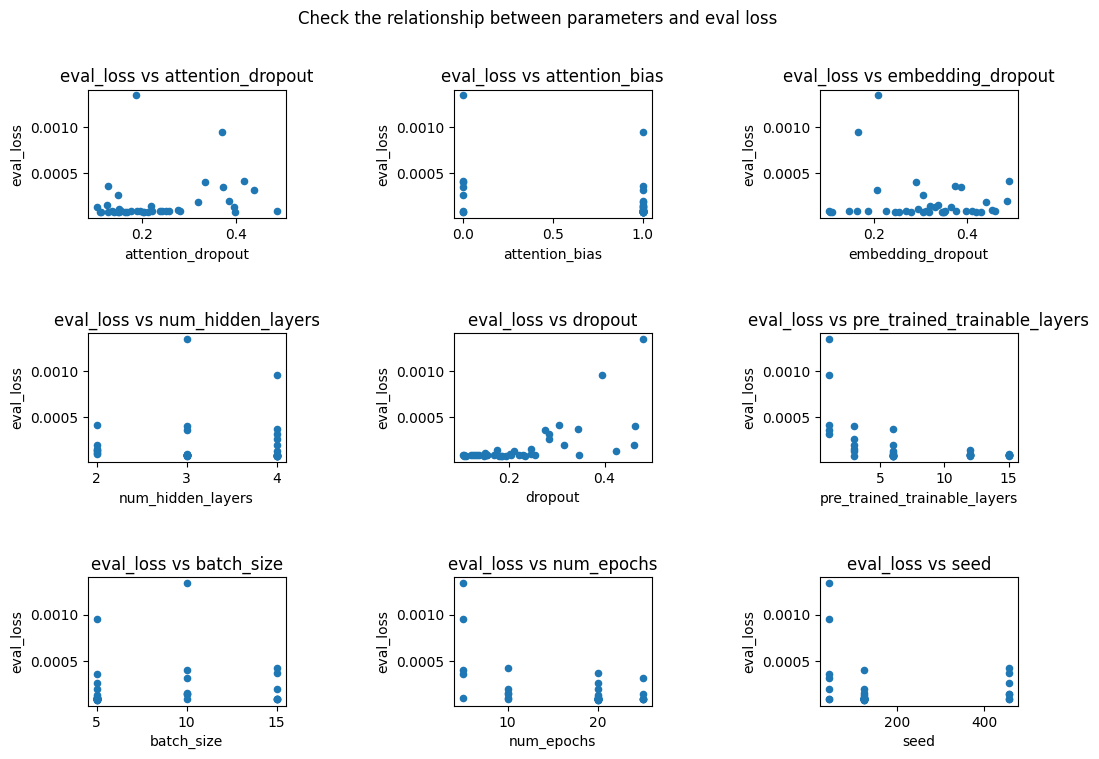

In [ ]:
# Quick analysis
trial_results_read['attention_bias']=trial_results_read['attention_bias'].astype(int)
param_feat_df = trial_results_read.drop(columns=['trial_number','train_loss','eval_loss'])
# target_loss_df = trail_results['val_loss']

n = len(param_feat_df.columns)
n_per_row=3

# for col in trail_results.drop(columns=['trial_number','train_loss','test_loss']):

if n%n_per_row==0:
    n_rows = n//n_per_row
else:
    n_rows = n//n_per_row+1
fig1, ax1 = plt.subplots(n_rows, n_per_row, figsize=(12,8))
for i, col in enumerate(param_feat_df.columns):
    trial_results_read[[col]+['eval_loss']].plot.scatter(x=col,y='eval_loss', ax=ax1[i//n_per_row, i%n_per_row])
    ax1[i//n_per_row, i%n_per_row].set_title(f'eval_loss vs {col}')
plt.suptitle('Check the relationship between parameters and eval loss')
plt.subplots_adjust(hspace=0.9, wspace=0.85)
plt.show()

In [ ]:
checkpoint_name

'checkpoint_14_train_val'

In [ ]:
%%time
# train the model (train-val) - result for current model
trainer_final.train()

with open(f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/trainer_state.json', "w") as f:
    json.dump(trainer_final.state.log_history, f)  #IN only added later..

# print(f'The best model checkpoint is: {trainer_final.state.best_model_checkpoint}')
# trainer_final.save_model(output_dir=f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/model_best')


CPU times: user 12min 18s, sys: 8.74 s, total: 12min 27s
Wall time: 11min 32s


# Load model

## For prediction model

### If load model from model checkpionts outside of study trials:

In [ ]:
checkpoint_name = 'checkpoint_9'  #checkpoint_0, checkpoint_1
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-1' # for checkpoint0
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-350' # for checkpoint_13
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-700' # for checkpoint1, checkpoint6, checkpoint7, checkpoint_14,
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-1400' # for checkpoint2, checkpoint3, checkpoint4, checkpoint5, checkpoint_9, checkpoint_12, checkpoint_17
model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-1330' # for checkpoint9 (by val loss)
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-1750' # for checkpoint8 (second version)
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-1050' # for checkpoint_11
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-630' # for  checkpoint_15, checkpoint_19 (last)
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-420' # for  checkpoint_16
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/model_best' # for best by loss (mse), model 18-23, model 13-14 (retrained)
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-1600' # for  checkpoint_9_train_val
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-800' # for  checkpoint_7_train_val
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-960' # for  checkpoint_18_0_train_val
# model_path = f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/checkpoint-1200' # for  checkpoint_14_train_val

# if load from manually tuned model
model_trained = MBERT_Prediction_Model()

# if load from machine tuned model
# # if model is trial 18_0
# model_trained = MBERT_Prediction_Model_tuned(num_hidden_layers=4, dropout=0.15347, output_dim=len(tgt_cols), pre_trained_trainable_layers=6,
#                attention_bias=False, attention_dropout=0.242207, embedding_dropout = 0.103435)

# if model is trial 14
# model_trained = MBERT_Prediction_Model_tuned(num_hidden_layers=4, dropout=0.15347, output_dim=len(tgt_cols), pre_trained_trainable_layers=6,
#                attention_bias=False, attention_dropout=0.242207, embedding_dropout = 0.103435)

### If load model from study trial models:

In [ ]:
study_checkpoint = 'study_checkpoint2'
study_dir = f'{BASE_DIR}/model_checkpoints/{study_checkpoint}_reg/'
model_name = 'model_trial_11' # model_trial_18_0 (840), model_trial_11 (1260), model_trial_14, model_trial_19 (700), model_trial_15 (1050), model_trial_22 (490)
checkpoint_model_epoch = 'checkpoint-1260'  # 'checkpoint-840', 'checkpoint-1260', 'checkpoint-1050',  'checkpoint-700', 'checkpoint-1050', 'checkpoint-490'
model_path = f'{study_dir}/trial_models/{model_name}/{checkpoint_model_epoch}'

# # for model trial 18 (18_0)
# model_trained = MBERT_Prediction_Model_tuned(num_hidden_layers=4, dropout=0.15347, output_dim=len(tgt_cols), pre_trained_trainable_layers=6,
#                attention_bias=False, attention_dropout=0.242207, embedding_dropout = 0.103435)

# for model trial 11
model_trained = MBERT_Prediction_Model_tuned(num_hidden_layers=4, dropout=0.10567, output_dim=len(tgt_cols), pre_trained_trainable_layers=6,
               attention_bias=False, attention_dropout=0.204059, embedding_dropout = 0.304526)

# # for model trial 14
# model_trained = MBERT_Prediction_Model_tuned(num_hidden_layers=4, dropout=0.18522, output_dim=len(tgt_cols), pre_trained_trainable_layers=6,
#                attention_bias=False, attention_dropout=0.126992, embedding_dropout = 0.110473)

# # for model trial 19
# model_trained = MBERT_Prediction_Model_tuned(num_hidden_layers=3, dropout=0.2327, output_dim=len(tgt_cols), pre_trained_trainable_layers=12,
#                attention_bias=False, attention_dropout=0.150227, embedding_dropout = 0.351117)

# # for model trial 15
# model_trained = MBERT_Prediction_Model_tuned(num_hidden_layers=4, dropout=0.181995, output_dim=len(tgt_cols), pre_trained_trainable_layers=6,
#                attention_bias=False, attention_dropout=0.11106, embedding_dropout = 0.253608)

# # for model trial 22
# model_trained = MBERT_Prediction_Model_tuned(num_hidden_layers=3, dropout=0.146901, output_dim=len(tgt_cols), pre_trained_trainable_layers=15,
#                attention_bias=False, attention_dropout=0.147961, embedding_dropout = 0.348544)


### Load model - shared code

In [ ]:
#IN: note if saved under HF trainer, need to load it differently from typical
state_dict = load_file(f'{model_path}/model.safetensors')
model_trained.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
with open(f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_fomc_model/trainer_state.json') as f:
    log_history = json.load(f)

Training loss: [0.065, 0.0042, 0.0013, 0.0009, 0.0008, 0.0007, 0.0006, 0.0006, 0.0005, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003]
Validation loss: [0.0012577896704897285, 0.0001828521490097046, 0.00033596731373108923, 0.00032015328179113567, 0.00019800370500888675, 0.00014683289919048548, 0.00015237937623169273, 0.00014135830861050636, 0.00015617624740116298, 0.0001231635978911072, 0.0001456070749554783, 0.00010730821668403223, 9.673498425399885e-05, 9.570460679242387e-05, 9.531492105452344e-05, 9.591336129233241e-05, 9.291023161495104e-05, 8.921973494580016e-05, 8.778932533459738e-05, 8.934840298024938e-05]


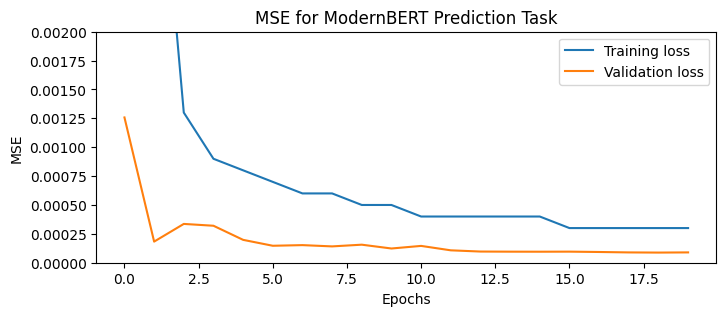

In [ ]:
train_loss =[]
eval_loss = []
train_loss_tr = 0
train_count_tr = 0

for i in range(len(log_history)):
  if 'loss' in log_history[i]:
    train_loss_tr += log_history[i]['loss']
    train_count_tr += 1
  if 'eval_loss' in log_history[i]:
    train_loss.append(train_loss_tr/train_count_tr)
    eval_loss.append(log_history[i]['eval_loss'])

    train_loss_tr = 0
    train_count_tr = 0

print('Training loss:', train_loss)
print('Validation loss:', eval_loss)

train_val_loss_df = pd.DataFrame({'Training loss': train_loss, 'Validation loss': eval_loss})
train_val_loss_df.plot(figsize=(8,3), title='MSE for ModernBERT Prediction Task')
plt.ylim(0,0.002)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## For classification model

In [ ]:
# model_trained.eval()
cl_checkpoint_name = 'cl_checkpoint_4' # cl_checkpoint_1, cl_checkpoint_2, cl_checkpoint_3
# model_path = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/checkpoint-1' # for checkpoint0
# model_path_cl = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/checkpoint-700' # for checkpoint1, checkpoint6, checkpoint7
# model_path = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/checkpoint-1400' # for checkpoint2, checkpoint3, checkpoint4, checkpoint5,
# model_path_cl = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/checkpoint-1750' # for checkpoint8
# model_path_cl = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/checkpoint-630' # for checkpoint8
# model_path_cl = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/checkpoint-560' # for cl_checkpoint_3 best by accuracy
# model_path_cl = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/checkpoint-350' # for cl_checkpoint_3 best by loss
# model_path_cl = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/checkpoint-420' # for cl_checkpoint_4 best by accuracy
model_path_cl = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/checkpoint-280' # for cl_checkpoint_4 best by loss
# model_path_cl = f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/model_best' # for best by loss, cl_checkpoint_5, cl_checkpoint_6, cl_checkpoint_7, cl_checkpoint_8, cl_checkpoint_9

In [ ]:
#IN: note if saved under HF trainer, need to load it differently from typical
model_trained_cl = MBERT_Classification_Model()
state_dict_cl = load_file(f'{model_path_cl}/model.safetensors')
model_trained_cl.load_state_dict(state_dict_cl)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [ ]:
with open(f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_fomc_model/trainer_state.json') as f:
    log_history_cl = json.load(f)

Training loss: [0.7997, 0.6968, 0.7466, 0.6588, 0.5028, 0.1723, 0.0036, 0.0002, 0.0001]
Validation loss: [0.7036436200141907, 0.6903604865074158, 0.6894112229347229, 0.6704680323600769, 0.7373743057250977, 1.5289907455444336, 1.6233428716659546, 1.5397720336914062, 1.5639972686767578]
Validation accuracy: [0.6041666666666666, 0.5833333333333334, 0.5833333333333334, 0.6458333333333334, 0.625, 0.6458333333333334, 0.5833333333333334, 0.5833333333333334, 0.625]


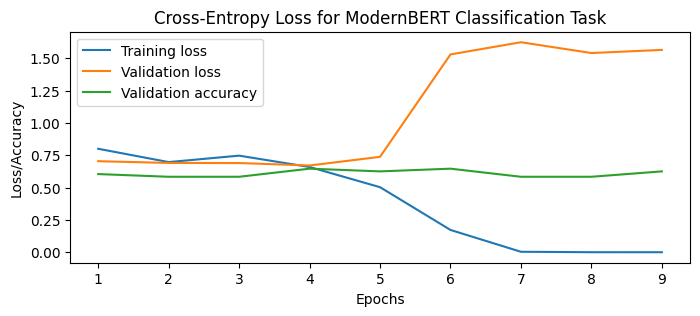

In [ ]:
train_loss_cl =[]
eval_loss_cl = []
eval_accuracy_cl = []  #IN
train_loss_tr = 0
train_count_tr = 0

for i in range(len(log_history_cl)):
  if 'loss' in log_history_cl[i]:
    train_loss_tr += log_history_cl[i]['loss']
    train_count_tr += 1
  if 'eval_loss' in log_history_cl[i]:
    train_loss_cl.append(train_loss_tr/train_count_tr)
    eval_loss_cl.append(log_history_cl[i]['eval_loss'])
    eval_accuracy_cl.append(log_history_cl[i]['eval_Accuracy']) #IN

    train_loss_tr = 0
    train_count_tr = 0

print('Training loss:', train_loss_cl)
print('Validation loss:', eval_loss_cl)
print('Validation accuracy:', eval_accuracy_cl) #IN

train_val_loss_df_cl = pd.DataFrame({'Training loss': train_loss_cl, 'Validation loss': eval_loss_cl,
                                     'Validation accuracy': eval_accuracy_cl},
                                    index=range(1, len(eval_loss_cl)+1))
train_val_loss_df_cl.plot(figsize=(8,3), title='Cross-Entropy Loss for ModernBERT Classification Task')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.show()

# Check model results

## For prediction model

### For train_val period only

In [ ]:
# alternatively using HF trainer class method
training_args_eval = TrainingArguments(
    # output_dir=f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_preds', #'' will be current directory, if specified dir doesn't exist the program will create one matching
    per_device_eval_batch_size=16,
    report_to="none"  # Avoids logging to W&B
)

trainer_pred = Trainer(model=model_trained, args=training_args_eval)
# output = trainer_pred.predict(train_dataset_preprocessed.with_format("torch"))
output = trainer_pred.predict(train_val_dataset_preprocessed.with_format('torch'))
# output.last_hidden_state.shape
# output.predictions.shape
preds, labels  = output.predictions, output.label_ids

In [ ]:
checkpoint_name

'checkpoint_9'

In [ ]:
preds.shape

(396, 3)

In [ ]:
# Put prediction in dataframe with corresponding dates
dateindex_train = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(train_dataset.dates[i].item()).normalize() for i in range(len(train_dataset))])
dateindex_val = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(val_dataset.dates[i].item()).normalize() for i in range(len(val_dataset))])
dateindex = dateindex_train.append(dateindex_val)

pred_df = pd.DataFrame(preds, index = dateindex, columns=tgt_cols)
tgt_df = pd.DataFrame(labels, index = dateindex, columns=tgt_cols)

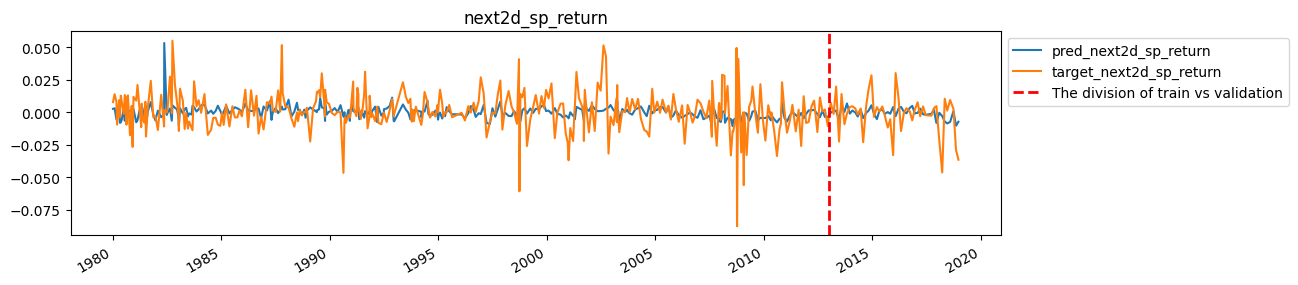

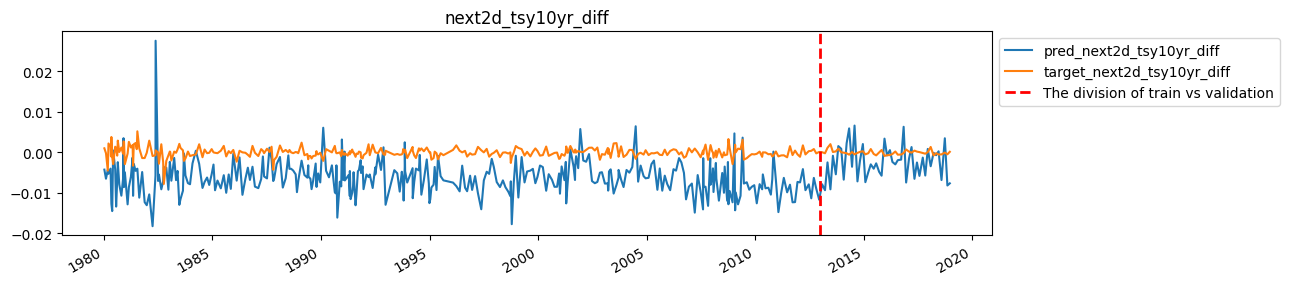

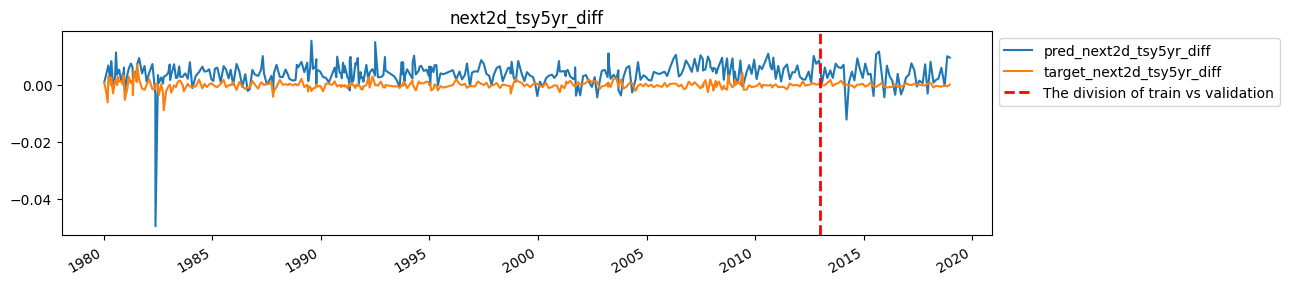

In [ ]:
# Quick comparison charts
for col in tgt_cols:
  # pd.concat([pred_df[col].rename(f'pred_{col}'), tgt_df[col].rename(f'target_{col}')], axis=1).plot.bar(title=col, figsize=(12,3))
  pd.concat([pred_df[col].rename(f'pred_{col}'), tgt_df[col].rename(f'target_{col}')], axis=1).plot(title=col, figsize=(12,3))
  plt.axvline(x='2012-12-31', color='red', linestyle='--', linewidth=2, label='The division of train vs validation')
  plt.legend(bbox_to_anchor=(1, 1))
  plt.show()

In [ ]:
# Manually calculate the direction prediction accuracy
# accuracy_df = pd.DataFrame(index=['accuracy'], columns=tgt_cols)

accuracy_df = pd.DataFrame(index=['Train_accuracy', 'Val_accuracy',
                                  'Train_MSE', 'Val_MSE'], columns=tgt_cols)

for col in tgt_cols:
  # accuracy_df.loc['accuracy', col] = np.mean(np.sign(pred_df[col])==np.sign(tgt_df[col]))

  pred_df_train = pred_df[pred_df.index.year<=train_years[1]]
  pred_df_val = pred_df[(pred_df.index.year>=val_years[0])&(pred_df.index.year<=val_years[1])]

  tgt_df_train = tgt_df[tgt_df.index.year<=train_years[1]]
  tgt_df_val = tgt_df[(tgt_df.index.year>=val_years[0])&(tgt_df.index.year<=val_years[1])]

  accuracy_df.loc['Train_accuracy', col] = np.mean(np.sign(pred_df_train[col])==np.sign(tgt_df_train[col]))
  accuracy_df.loc['Val_accuracy', col] = np.mean(np.sign(pred_df_val[col])==np.sign(tgt_df_val[col]))

  accuracy_df.loc['Train_MSE', col] = np.mean((pred_df_train[col]-tgt_df_train[col])**2)
  accuracy_df.loc['Val_MSE', col] = np.mean((pred_df_val[col]-tgt_df_val[col])**2)

accuracy_df

next2d_sp_return next2d_tsy10yr_diff next2d_tsy5yr_diff
Train_accuracy          0.58046                 0.5           0.439655
Val_accuracy           0.541667            0.458333           0.458333
Train_MSE              0.000224             0.00006           0.000037
Val_MSE                0.000207            0.000024           0.000032

In [ ]:
# calculation check
from sklearn.metrics import mean_squared_error
print (col)
mean_squared_error(pred_df_train[col], tgt_df_train[col]) ==  np.mean((pred_df_train[col]-tgt_df_train[col])**2)

next2d_tsy5yr_diff


np.True_

### For full sample period

In [ ]:
# evaluate on test data, and predict for the all data (train, val and test)
training_args_eval = TrainingArguments(
    # output_dir=f'{BASE_DIR}/model_checkpoints/{checkpoint_name}_preds', #'' will be current directory, if specified dir doesn't exist the program will create one matching
    per_device_eval_batch_size=16,
    report_to="none"  # Avoids logging to W&B
)

trainer_pred_fs = Trainer(model=model_trained, args=training_args_eval)

eval_result_test = trainer_pred_fs.evaluate(test_dataset_preprocessed)
print(f'Test loss: {eval_result_test["eval_loss"]}')

output_fs = trainer_pred_fs.predict(train_val_test_dataset_preprocessed.with_format('torch'))
# output.last_hidden_state.shape
# output.predictions.shape
preds_fs, labels_fs  = output_fs.predictions, output_fs.label_ids

W0405 01:37:13.898000 6514 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Test loss: 0.00013212105841375887


In [ ]:
checkpoint_name

'checkpoint_9'

In [ ]:
preds_fs.shape

(445, 3)

In [ ]:
# Put prediction in dataframe with corresponding dates
dateindex_train = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(train_dataset.dates[i].item()).normalize() for i in range(len(train_dataset))])
dateindex_val = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(val_dataset.dates[i].item()).normalize() for i in range(len(val_dataset))])
dateindex_test = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(test_dataset.dates[i].item()).normalize() for i in range(len(test_dataset))])
dateindex = dateindex_train.append(dateindex_val)
dateindex_fs = dateindex.append(dateindex_test)

pred_df_fs = pd.DataFrame(preds_fs, index = dateindex_fs, columns=tgt_cols)
tgt_df_fs = pd.DataFrame(labels_fs, index = dateindex_fs, columns=tgt_cols)

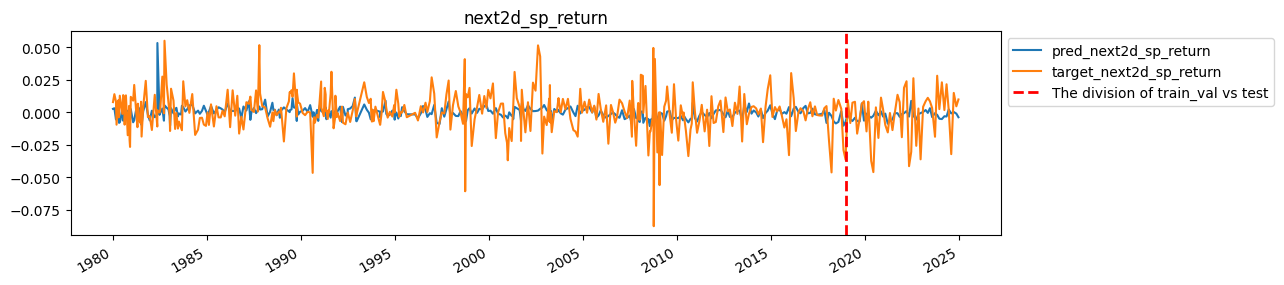

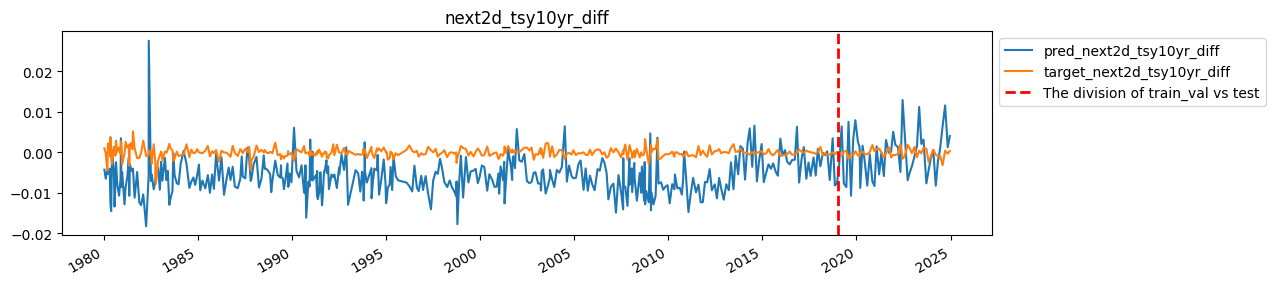

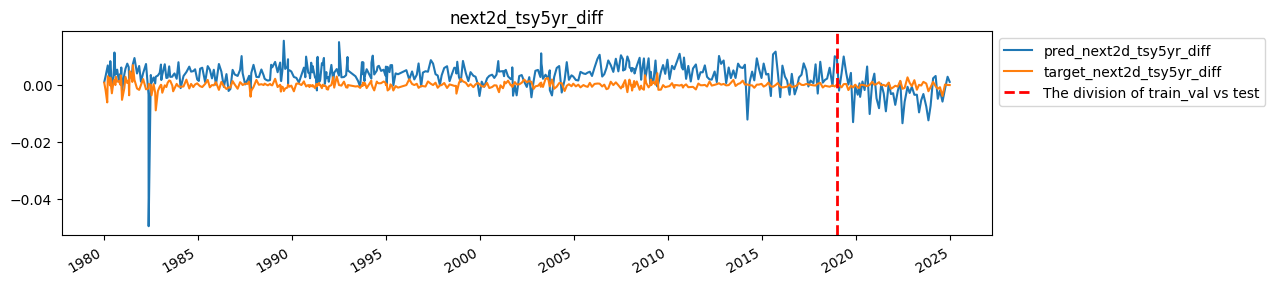

In [ ]:
# Quick comparison charts
for col in tgt_cols:
  pd.concat([pred_df_fs[col].rename(f'pred_{col}'), tgt_df_fs[col].rename(f'target_{col}')], axis=1).plot(title=col, figsize=(12,3))
  plt.axvline(x='2018-12-31', color='red', linestyle='--', linewidth=2, label='The division of train_val vs test')
  plt.legend(bbox_to_anchor=(1, 1))
  plt.show()

In [ ]:
# Manually calculate the direction prediction accuracy

accuracy_df_fs = pd.DataFrame(index=['In-sample_direction_accuracy', 'Test_direction_accuracy',
                                  'In-sample_MSE', 'Test_MSE'], columns=tgt_cols)

for col in tgt_cols:
  # accuracy_df.loc['accuracy', col] = np.mean(np.sign(pred_df[col])==np.sign(tgt_df[col]))

  pred_df_train_fs = pred_df_fs[pred_df_fs.index.year<=val_years[1]]
  pred_df_test_fs = pred_df_fs[(pred_df_fs.index.year>=test_years[0])&(pred_df_fs.index.year<=test_years[1])]

  tgt_df_train_fs = tgt_df_fs[tgt_df_fs.index.year<=val_years[1]]
  tgt_df_test_fs = tgt_df_fs[(tgt_df_fs.index.year>=test_years[0])&(tgt_df_fs.index.year<=test_years[1])]

  accuracy_df_fs.loc['In-sample_direction_accuracy', col] = np.mean(np.sign(pred_df_train_fs[col])==np.sign(tgt_df_train_fs[col]))
  accuracy_df_fs.loc['Test_direction_accuracy', col] = np.mean(np.sign(pred_df_test_fs[col])==np.sign(tgt_df_test_fs[col]))

  accuracy_df_fs.loc['In-sample_MSE', col] = np.mean((pred_df_train_fs[col]-tgt_df_train_fs[col])**2)
  accuracy_df_fs.loc['Test_MSE', col] = np.mean((pred_df_test_fs[col]-tgt_df_test_fs[col])**2)

accuracy_df_fs

next2d_sp_return next2d_tsy10yr_diff  \
In-sample_direction_accuracy         0.575758            0.494949   
Test_direction_accuracy               0.55102            0.367347   
In-sample_MSE                        0.000222            0.000055   
Test_MSE                             0.000331            0.000037   

                             next2d_tsy5yr_diff  
In-sample_direction_accuracy           0.441919  
Test_direction_accuracy                 0.55102  
In-sample_MSE                          0.000036  
Test_MSE                               0.000028

In [ ]:
# calculation check
from sklearn.metrics import mean_squared_error
print (col)
mean_squared_error(pred_df_train_fs[col], tgt_df_train_fs[col]) ==  np.mean((pred_df_train_fs[col]-tgt_df_train_fs[col])**2)

next2d_tsy5yr_diff


np.True_

## For classification model

### For train and val period - CL

In [ ]:
# alternatively using HF trainer class method
training_args_eval_cl = TrainingArguments(
    output_dir=f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_preds', #'' will be current directory, if specified dir doesn't exist the program will create one matching
    per_device_eval_batch_size=16,
    report_to="none"  # Avoids logging to W&B
)

trainer_pred_cl = Trainer(model=model_trained_cl, args=training_args_eval_cl)
# output_cl = trainer_pred_cl.predict(train_dataset_preprocessed_cl.with_format("torch"))
output_cl = trainer_pred_cl.predict(train_val_dataset_preprocessed_cl.with_format("torch"))
# output.last_hidden_state.shape
# output.predictions.shape
preds_cl_logit, labels_cl  = output_cl.predictions, output_cl.label_ids
preds_cl = preds_cl_logit.argmax(axis=1) # or np.argmax(preds_cl_logit, axis=-1)

In [ ]:
cl_checkpoint_name

'cl_checkpoint_4'

In [ ]:
train_val_dataset_preprocessed_cl

Dataset({
    features: ['input_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 396
})

In [ ]:
# Put prediction in dataframe with corresponding dates
dateindex_train = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(train_dataset.dates[i].item()).normalize() for i in range(len(train_dataset))])
dateindex_val = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(val_dataset.dates[i].item()).normalize() for i in range(len(val_dataset))])
dateindex = dateindex_train.append(dateindex_val)

pred_df_cl = pd.DataFrame(preds_cl, index = dateindex, columns=['sp_rtn_sign'])
tgt_df_cl = pd.DataFrame(labels_cl, index = dateindex, columns=['sp_rtn_sign'])

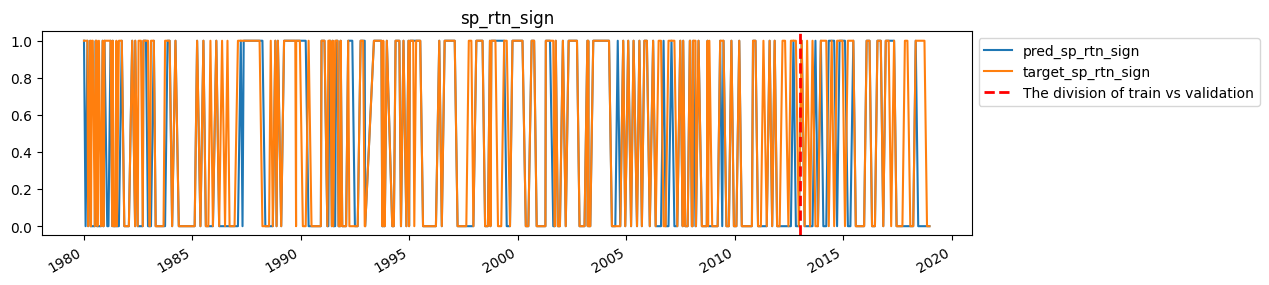

In [ ]:
# Quick comparison charts
for col in tgt_df_cl.columns:
  pd.concat([pred_df_cl[col].rename(f'pred_{col}'), tgt_df_cl[col].rename(f'target_{col}')], axis=1).plot(title=col, figsize=(12,3))
  plt.axvline(x='2012-12-31', color='red', linestyle='--', linewidth=2, label='The division of train vs validation')
  plt.legend(bbox_to_anchor=(1, 1))
  plt.show()

In [ ]:
# Manually calculate the direction prediction accuracy
accuracy_df_cl = pd.DataFrame(index=['Train_accuracy', 'Val_accuracy'], columns=tgt_df_cl.columns)

for col in tgt_df_cl.columns:
  # accuracy_df_cl.loc['accuracy', col] = np.mean(np.sign(pred_df_cl[col])==np.sign(tgt_df_cl[col]))

  pred_df_train_cl = pred_df_cl[pred_df_cl.index.year<=train_years[1]]
  pred_df_val_cl = pred_df_cl[(pred_df_cl.index.year>=val_years[0])&(pred_df_cl.index.year<=val_years[1])]

  tgt_df_train_cl = tgt_df_cl[tgt_df_cl.index.year<=train_years[1]]
  tgt_df_val_cl = tgt_df_cl[(tgt_df_cl.index.year>=val_years[0])&(tgt_df_cl.index.year<=val_years[1])]

  accuracy_df_cl.loc['Train_accuracy', col] = np.mean(np.sign(pred_df_train_cl[col])==np.sign(tgt_df_train_cl[col]))
  accuracy_df_cl.loc['Val_accuracy', col] = np.mean(np.sign(pred_df_val_cl[col])==np.sign(tgt_df_val_cl[col]))

accuracy_df_cl

sp_rtn_sign
Train_accuracy    0.850575
Val_accuracy      0.645833

### For Full sample period - CL

In [ ]:
# alternatively using HF trainer class method
training_args_eval_cl = TrainingArguments(
    output_dir=f'{BASE_DIR}/model_checkpoints/{cl_checkpoint_name}_preds', #'' will be current directory, if specified dir doesn't exist the program will create one matching
    per_device_eval_batch_size=16,
    report_to="none"  # Avoids logging to W&B
)

trainer_pred_cl_fs = Trainer(model=model_trained_cl, args=training_args_eval_cl)

eval_result_test_cl = trainer_pred_cl_fs.evaluate(test_dataset_preprocessed_cl)
print(f'Test loss: {eval_result_test_cl["eval_loss"]}')


output_cl_fs = trainer_pred_cl_fs.predict(train_val_test_dataset_preprocessed_cl.with_format("torch"))
# output.last_hidden_state.shape
# output.predictions.shape
preds_cl_logit_fs, labels_cl_fs  = output_cl_fs.predictions, output_cl_fs.label_ids
preds_cl_fs = preds_cl_logit_fs.argmax(axis=1) # or np.argmax(preds_cl_logit, axis=-1)

Test loss: 0.740825355052948


In [ ]:
cl_checkpoint_name

'cl_checkpoint_4'

In [ ]:
preds_cl_fs.shape

(445,)

In [ ]:
train_val_test_dataset_preprocessed_cl

Dataset({
    features: ['input_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 445
})

In [ ]:
# Put prediction in dataframe with corresponding dates
dateindex_train = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(train_dataset.dates[i].item()).normalize() for i in range(len(train_dataset))])
dateindex_val = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(val_dataset.dates[i].item()).normalize() for i in range(len(val_dataset))])
dateindex_test = pd.DatetimeIndex([pd.Timestamp.fromtimestamp(test_dataset.dates[i].item()).normalize() for i in range(len(test_dataset))])
dateindex = dateindex_train.append(dateindex_val)
dateindex_fs = dateindex.append(dateindex_test)

pred_df_cl_fs = pd.DataFrame(preds_cl_fs, index = dateindex_fs, columns=['sp_rtn_sign'])
tgt_df_cl_fs = pd.DataFrame(labels_cl_fs, index = dateindex_fs, columns=['sp_rtn_sign'])

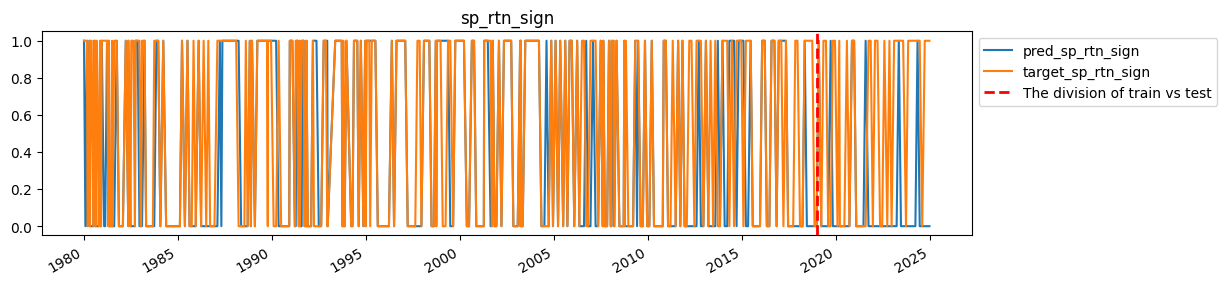

In [ ]:
# Quick comparison charts
for col in tgt_df_cl_fs.columns:
  pd.concat([pred_df_cl_fs[col].rename(f'pred_{col}'), tgt_df_cl_fs[col].rename(f'target_{col}')], axis=1).plot(title=col, figsize=(12,3))
  plt.axvline(x='2018-12-31', color='red', linestyle='--', linewidth=2, label='The division of train vs test')
  plt.legend(bbox_to_anchor=(1, 1))
  plt.show()

In [ ]:
# Manually calculate the direction prediction accuracy
accuracy_df_cl_fs = pd.DataFrame(index=['In-sample_accuracy', 'Test_accuracy'], columns=tgt_df_cl_fs.columns)

for col in tgt_df_cl_fs.columns:
  pred_df_train_cl_fs = pred_df_cl_fs[pred_df_cl_fs.index.year<=val_years[1]]
  pred_df_test_cl_fs = pred_df_cl_fs[(pred_df_cl_fs.index.year>=test_years[0])&(pred_df_cl_fs.index.year<=test_years[1])]

  tgt_df_train_cl_fs = tgt_df_cl_fs[tgt_df_cl_fs.index.year<=val_years[1]]
  tgt_df_test_cl_fs = tgt_df_cl_fs[(tgt_df_cl_fs.index.year>=test_years[0])&(tgt_df_cl_fs.index.year<=test_years[1])]

  accuracy_df_cl_fs.loc['In-sample_accuracy', col] = np.mean(np.sign(pred_df_train_cl_fs[col])==np.sign(tgt_df_train_cl_fs[col]))
  accuracy_df_cl_fs.loc['Test_accuracy', col] = np.mean(np.sign(pred_df_test_cl_fs[col])==np.sign(tgt_df_test_cl_fs[col]))

accuracy_df_cl_fs

sp_rtn_sign
In-sample_accuracy    0.825758
Test_accuracy         0.469388

# Backtest check

### Util functions for backtests

In [ ]:
def mmd_cal(df, return_col_name):
  df_used = df.copy()
  df_used['cum_rtn']=(1+df_used[return_col_name]).cumprod()
  df_used['drawdown'] = (df_used['cum_rtn']-df_used['cum_rtn'].cummax())/df_used['cum_rtn'].cummax()
  df_used['max_drawdown'] =  df_used['drawdown'].cummin()
  return df_used['max_drawdown']

def performance_cal_0(rtn_df, mkt_df, portf_name, vline_cutoff='2012-12-31',
                    vline_lable='Train vs Validation', plot_show=True):
  portf_mkt_rtn = pd.concat([rtn_df, mkt_df.rename('Unscaled Market').reindex(rtn_df.index).fillna(0)], axis=1)

  fig1, ax1 = plt.subplots(1,2, figsize=(11,3.5))
  portf_mkt_rtn.cumsum().plot(ax=ax1[0])
  ax1[0].set_title(f'Cumulative Return Comparison')
  ax1[0].legend(loc='upper left')
  ax1[0].axvline(x=vline_cutoff, color='red', linestyle='--', linewidth=1.5, label=vline_lable)
  ax1[0].legend(loc='upper left')
  # plt.legend()
  # plt.show()

  (portf_mkt_rtn.rolling(252).std()*np.sqrt(252)).plot(
      ax=ax1[1],
      title='Rolling Annual Vol Comparison')
  ax1[1].axvline(x=vline_cutoff, color='red', linestyle='--', linewidth=1.5, label=vline_lable)
  ax1[1].legend(loc='upper left')

  fig1.suptitle(f'{portf_name} vs (Scaled) S&P500 Cumulative Return and Rolling Vol Comparison')
  plt.subplots_adjust(top=0.85, bottom=0.01, wspace=0.2)
  if plot_show is True:
    plt.show()
  plt.close()

  stats_df = pd.DataFrame(columns=portf_mkt_rtn.columns)
  stats_df.loc['avg_rtn_ann',:] = portf_mkt_rtn.mean()*252
  stats_df.loc['vol_ann',:] = portf_mkt_rtn.std()*np.sqrt(252)
  stats_df.loc['sharpe_ann',:] = stats_df.loc['avg_rtn_ann',:]/stats_df.loc['vol_ann',:]
  stats_df.loc['max_drawdown','portf'] = mmd_cal(portf_mkt_rtn, 'portf').iloc[-1]
  stats_df.loc['max_drawdown','Unscaled Market'] = mmd_cal(portf_mkt_rtn, 'Unscaled Market').iloc[-1]
  # stats_df.loc['sharpe_ann_val',:] = (portf_mkt_rtn.loc[str(val_years[0]):str(val_years[1])].mean()*np.sqrt(252))\
  #                                       .div(portf_mkt_rtn.loc[str(val_years[0]):str(val_years[1])].std())
  if vline_cutoff == '2012-12-31':
    stats_df.loc['sharpe_ann_val',:] = (portf_mkt_rtn.loc[str(val_years[0]):str(val_years[1])].mean()*np.sqrt(252))\
                                        .div(portf_mkt_rtn.loc[str(val_years[0]):str(val_years[1])].std())
  elif vline_cutoff == '2018-12-31':
    stats_df.loc['sharpe_ann_test',:] = (portf_mkt_rtn.loc[str(test_years[0]):str(test_years[1])].mean()*np.sqrt(252))\
                                        .div(portf_mkt_rtn.loc[str(test_years[0]):str(test_years[1])].std())
  else:
    print ('Please check vline_cutoff!')


  if plot_show is True:
    print(stats_df)

  return portf_mkt_rtn, stats_df, fig1


def performance_cal(rtn_df_comb, portf_name, vline_cutoff='2012-12-31',
                    vline_lable='Train vs Validation', plot_show=True):

  fig1, ax1 = plt.subplots(1,2, figsize=(11,3.5))
  rtn_df_comb.cumsum().plot(ax=ax1[0])
  ax1[0].set_title(f'Cumulative Return Comparison')
  ax1[0].legend(loc='upper left')
  ax1[0].axvline(x=vline_cutoff, color='red', linestyle='--', linewidth=1.5, label=vline_lable)
  ax1[0].legend(loc='upper left')
  # plt.legend()
  # plt.show()

  (rtn_df_comb.rolling(252).std()*np.sqrt(252)).plot(
      ax=ax1[1],
      title='Rolling Annual Vol Comparison')
  ax1[1].axvline(x=vline_cutoff, color='red', linestyle='--', linewidth=1.5, label=vline_lable)
  ax1[1].legend(loc='upper left')


  fig1.suptitle(f'{portf_name} Cumulative Return and Rolling Vol Comparison')
  plt.subplots_adjust(top=0.85, bottom=0.01, wspace=0.2)
  if plot_show is True:
    plt.show()
  plt.close()

  stats_df = pd.DataFrame(columns=rtn_df_comb.columns)
  stats_df.loc['avg_rtn_ann',:] = portf_mkt_rtn.mean()*252
  stats_df.loc['vol_ann',:] = portf_mkt_rtn.std()*np.sqrt(252)
  stats_df.loc['sharpe_ann',:] = stats_df.loc['avg_rtn_ann',:]/stats_df.loc['vol_ann',:]
  for col in rtn_df_comb.columns:
    stats_df.loc['max_drawdown',col] = mmd_cal(rtn_df_comb, col).iloc[-1]

  if vline_cutoff == '2012-12-31':
    stats_df.loc['sharpe_ann_val',:] = (portf_mkt_rtn.loc[str(val_years[0]):str(val_years[1])].mean()*np.sqrt(252))\
                                        .div(portf_mkt_rtn.loc[str(val_years[0]):str(val_years[1])].std())
  elif vline_cutoff == '2018-12-31':
    stats_df.loc['sharpe_ann_test',:] = (portf_mkt_rtn.loc[str(test_years[0]):str(test_years[1])].mean()*np.sqrt(252))\
                                        .div(portf_mkt_rtn.loc[str(test_years[0]):str(test_years[1])].std())
  else:
    print ('Please check vline_cutoff!')

  if plot_show is True:
    print(stats_df)

  return stats_df, fig1

### If using classification results for direction only signal

#### If to perform backtest on train_val period

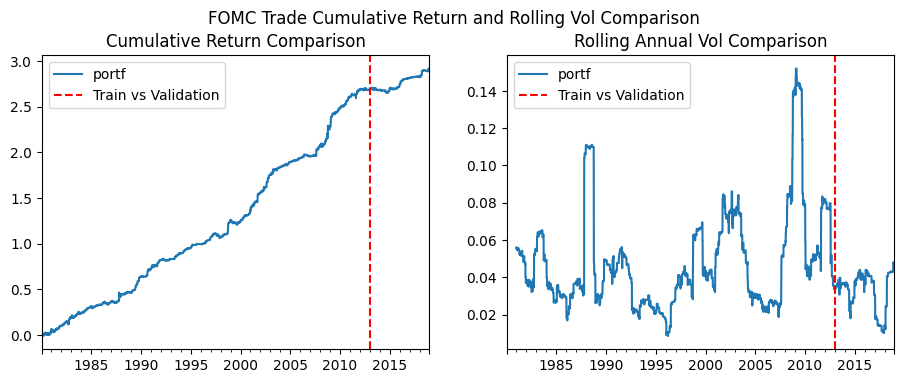

                   portf
avg_rtn_ann     0.072318
vol_ann         0.052449
sharpe_ann       1.37883
max_drawdown   -0.056241
sharpe_ann_val  1.027048


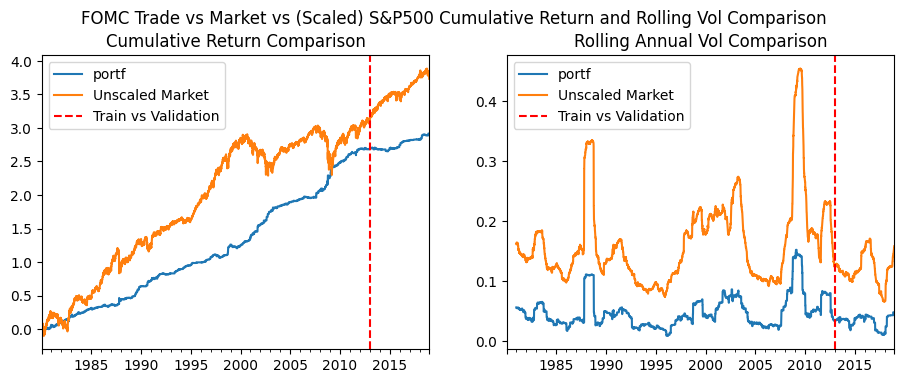

                   portf Unscaled Market
avg_rtn_ann     0.072318        0.092569
vol_ann         0.052449        0.171392
sharpe_ann       1.37883        0.540098
max_drawdown   -0.056241       -0.567754
sharpe_ann_val  1.027048        0.796158


In [ ]:
# Market data to be used:
train_val_mkt = pd.concat([train_mkt,val_mkt], axis=0)
mkt_data_df = train_val_mkt

# ## if using classification results
sig_df = pd.DataFrame(np.where(pred_df_cl['sp_rtn_sign']==1,1,0) \
                      + np.where(pred_df_cl['sp_rtn_sign']==0,-1,0), # handle positive and negative explicitly
                      index = pred_df_cl.index, columns = ['portf']).asfreq('B').fillna(0)

pos_df = sig_df.shift(1).fillna(0) + sig_df.shift(2).fillna(0) # hold the position for two days
pos_df = pos_df.asfreq('B').fillna(0)
instru_rtn_df = mkt_data_df.set_index('Date')['sp_return'].reindex(pos_df.index)

# # # simple backtest without transaction cost
rtn_df = pos_df.mul(instru_rtn_df.reindex(pos_df.index).fillna(0), axis=0)

# # plot performance and compare with market
mkt_df = mkt_data_df.set_index('Date')['sp_return']

portf_mkt_rtn = pd.concat([rtn_df, \
                           mkt_df.rename('Unscaled Market')], axis=1)
stats_df, fig_perf = \
    performance_cal(rtn_df, 'FOMC Trade', plot_show=True)

portf_mkt_rtn, stats_df, fig_perf = \
    performance_cal_0(rtn_df, mkt_data_df.set_index('Date')['sp_return'], 'FOMC Trade vs Market', plot_show=True)

#### If to perform backtest on full sample period

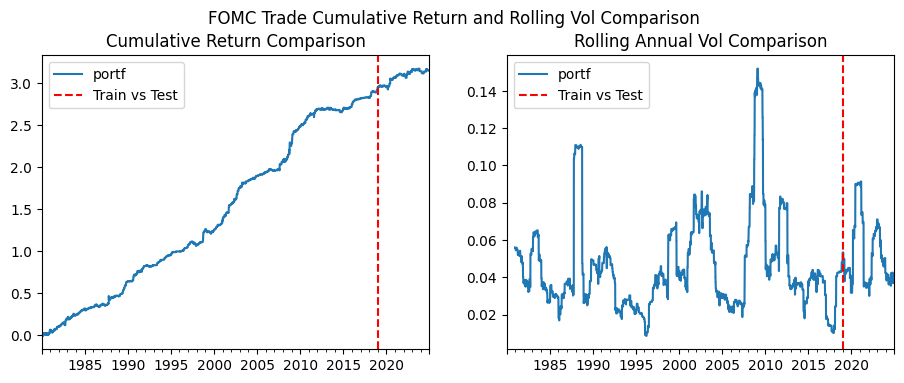

                    portf
avg_rtn_ann      0.067623
vol_ann          0.052944
sharpe_ann       1.277252
max_drawdown    -0.056241
sharpe_ann_test  0.569479


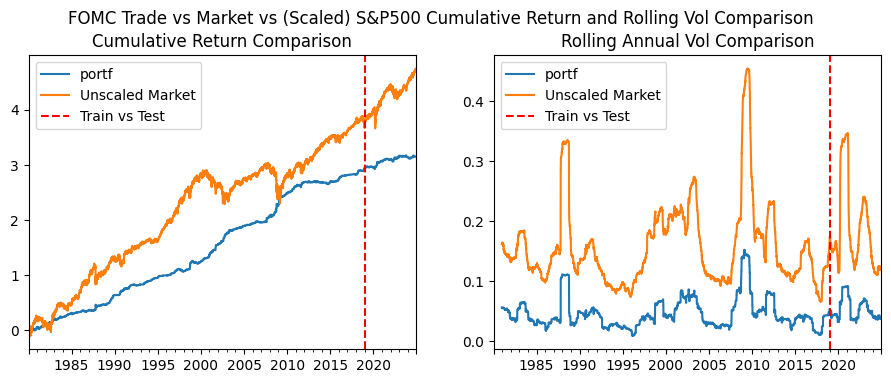

                    portf Unscaled Market
avg_rtn_ann      0.067623        0.101168
vol_ann          0.052944        0.175342
sharpe_ann       1.277252        0.576976
max_drawdown    -0.056241       -0.567754
sharpe_ann_test  0.569479        0.795467


In [ ]:
# Market data to be used:
train_val_test_mkt = pd.concat([train_mkt,val_mkt, test_mkt], axis=0)
mkt_data_df = train_val_test_mkt

# ## if using classification results
sig_df = pd.DataFrame(np.where(pred_df_cl_fs['sp_rtn_sign']==1,1,0) \
                      + np.where(pred_df_cl_fs['sp_rtn_sign']==0,-1,0), # handle positive and negative explicitly
                      index = pred_df_cl_fs.index, columns = ['portf']).asfreq('B').fillna(0)

pos_df = sig_df.shift(1).fillna(0) + sig_df.shift(2).fillna(0) # hold the position for two days
pos_df = pos_df.asfreq('B').fillna(0)
instru_rtn_df = mkt_data_df.set_index('Date')['sp_return'].reindex(pos_df.index)

# # # simple backtest without transaction cost
rtn_df = pos_df.mul(instru_rtn_df.reindex(pos_df.index).fillna(0), axis=0)

# # plot performance and compare with market
mkt_df = mkt_data_df.set_index('Date')['sp_return']

portf_mkt_rtn = pd.concat([rtn_df, \
                           mkt_df.rename('Unscaled Market')], axis=1)
stats_df, fig_perf = \
    performance_cal(rtn_df, 'FOMC Trade', vline_cutoff='2018-12-31',
                    vline_lable='Train vs Test', plot_show=True)

portf_mkt_rtn, stats_df, fig_perf = \
    performance_cal_0(rtn_df, mkt_data_df.set_index('Date')['sp_return'], 'FOMC Trade vs Market',
                      vline_cutoff='2018-12-31',
                    vline_lable='Train vs Test', plot_show=True)

### If using regression results for magnitude based signal

#### If to perform backtest on train_val period

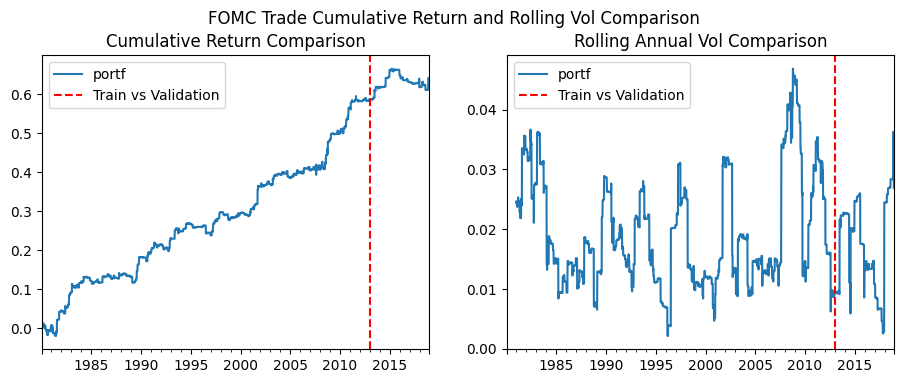

                   portf
avg_rtn_ann     0.015895
vol_ann         0.021213
sharpe_ann       0.74928
max_drawdown   -0.053615
sharpe_ann_val  0.414868


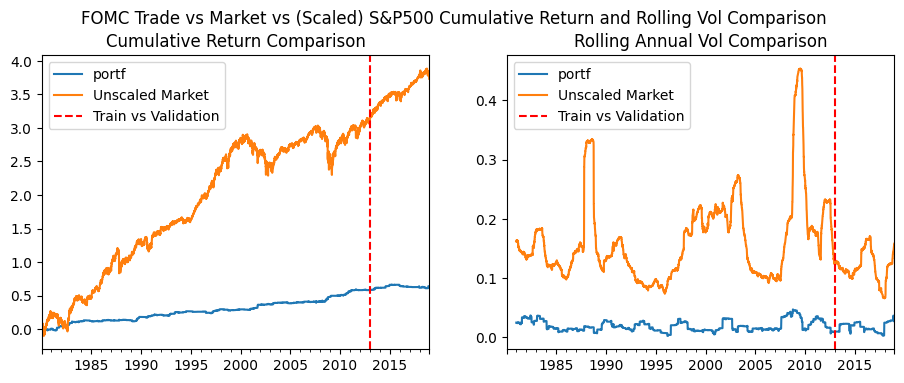

                   portf Unscaled Market
avg_rtn_ann     0.015895        0.092569
vol_ann         0.021213        0.171392
sharpe_ann       0.74928        0.540098
max_drawdown   -0.053615       -0.567754
sharpe_ann_val  0.414868        0.796158


In [ ]:
# use magnitude as well
# Market data to be used:
train_val_mkt = pd.concat([train_mkt,val_mkt], axis=0)
mkt_data_df = train_val_mkt

sig_df = pred_df['next2d_sp_return'].rename('portf').to_frame().asfreq('B').fillna(0)
instru_rtn_df = mkt_data_df.set_index('Date')['sp_return'].reindex(sig_df.index)
sig_df_adj = sig_df.div(instru_rtn_df.fillna(0).rolling(60, min_periods=2).std().bfill(), axis=0) # vol adjusted
pos_df = sig_df_adj.shift(1).fillna(0) + sig_df_adj.shift(2).fillna(0) # hold the position for two days
pos_df = pos_df.asfreq('B').fillna(0)

# # # simple backtest without transaction cost
rtn_df = pos_df.mul(instru_rtn_df.reindex(pos_df.index).fillna(0), axis=0)

# # plot performance and compare with market
mkt_df = mkt_data_df.set_index('Date')['sp_return']

portf_mkt_rtn = pd.concat([rtn_df, \
                           mkt_df.rename('Unscaled Market')], axis=1)
stats_df, fig_perf = \
    performance_cal(rtn_df, 'FOMC Trade', plot_show=True)

portf_mkt_rtn, stats_df, fig_perf = \
    performance_cal_0(rtn_df, mkt_data_df.set_index('Date')['sp_return'], 'FOMC Trade vs Market', plot_show=True)

#### If to perform backtest on full sampel period - train, val, test

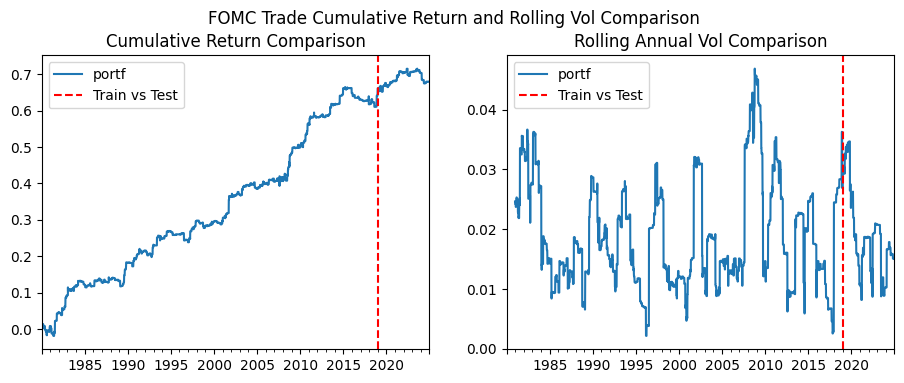

                    portf
avg_rtn_ann      0.014594
vol_ann          0.020841
sharpe_ann        0.70024
max_drawdown    -0.053615
sharpe_ann_test  0.169096


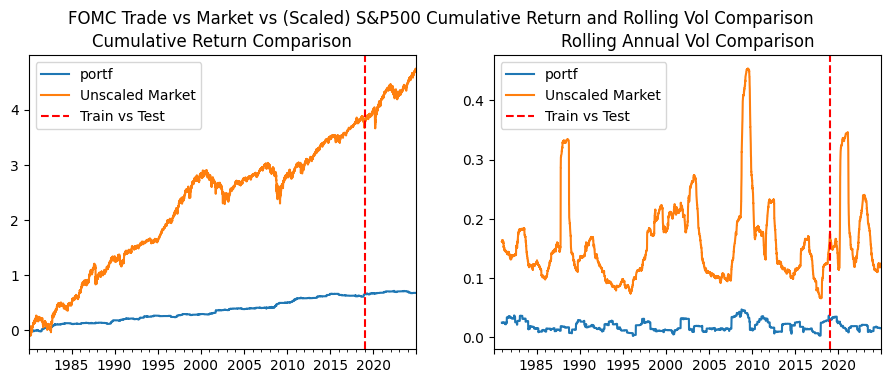

                    portf Unscaled Market
avg_rtn_ann      0.014594        0.101168
vol_ann          0.020841        0.175342
sharpe_ann        0.70024        0.576976
max_drawdown    -0.053615       -0.567754
sharpe_ann_test  0.169096        0.795467


In [ ]:
train_val_test_mkt = pd.concat([train_mkt,val_mkt, test_mkt], axis=0)
mkt_data_df = train_val_test_mkt

sig_df = pred_df_fs['next2d_sp_return'].rename('portf').to_frame().asfreq('B').fillna(0)
instru_rtn_df = mkt_data_df.set_index('Date')['sp_return'].reindex(sig_df.index)
sig_df_adj = sig_df.div(instru_rtn_df.fillna(0).rolling(60, min_periods=2).std().bfill(), axis=0) # vol adjusted
pos_df = sig_df_adj.shift(1).fillna(0) + sig_df_adj.shift(2).fillna(0) # hold the position for two days
pos_df = pos_df.asfreq('B').fillna(0)

# # # simple backtest without transaction cost
rtn_df = pos_df.mul(instru_rtn_df.reindex(pos_df.index).fillna(0), axis=0)

# # plot performance and compare with market
mkt_df = mkt_data_df.set_index('Date')['sp_return']

portf_mkt_rtn = pd.concat([rtn_df, \
                           mkt_df.rename('Unscaled Market')], axis=1)
stats_df, fig_perf = \
    performance_cal(rtn_df, 'FOMC Trade', vline_cutoff='2018-12-31',
                    vline_lable='Train vs Test', plot_show=True)

portf_mkt_rtn, stats_df, fig_perf = \
    performance_cal_0(rtn_df, mkt_data_df.set_index('Date')['sp_return'], 'FOMC Trade vs Market',
                    vline_cutoff='2018-12-31',
                    vline_lable='Train vs Test', plot_show=True)